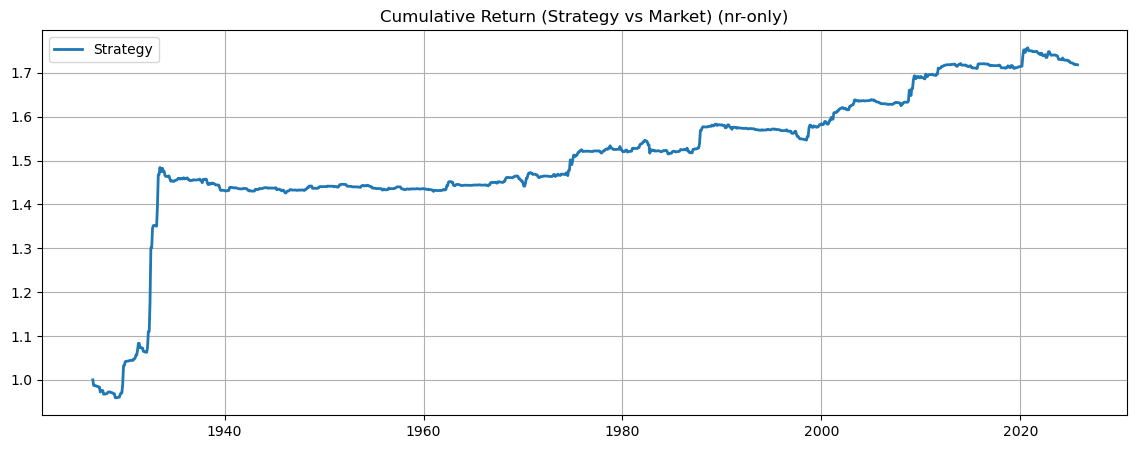

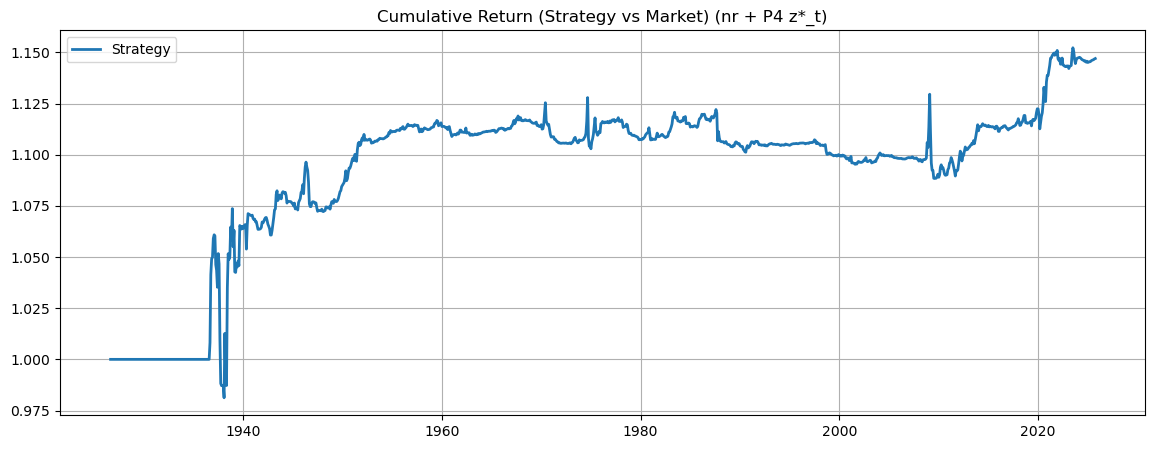

In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import statsmodels.api as sm


# ======================================================================
# 1. Ken French 元ファイルから月次部分だけ抽出（あなたの元コード）
# ======================================================================

def load_ff_monthly_from_ken_french(csv_path: str) -> pd.DataFrame:
    raw = pd.read_csv(csv_path, skiprows=4)

    num = pd.to_numeric(raw['Unnamed: 0'], errors='coerce')
    mask_monthly = num > 10000
    monthly = raw[mask_monthly].copy()

    monthly = monthly.rename(columns={'Unnamed: 0': 'date'})
    monthly['date'] = pd.to_datetime(monthly['date'].astype(int), format="%Y%m")
    monthly = monthly.set_index('date').sort_index()

    for col in ['Mkt-RF', 'RF']:
        monthly[col] = pd.to_numeric(monthly[col], errors='coerce')

    ff = monthly[['Mkt-RF', 'RF']].copy()
    ff['mkt_excess'] = ff['Mkt-RF'] / 100.0
    ff['rf']         = ff['RF'] / 100.0

    return ff[['mkt_excess', 'rf']].dropna()


# ======================================================================
# 2. 月タイプ分類（あなたの元コード）
# ======================================================================

def classify_month_type(index):
    mt = pd.Series(index=index, dtype="object")
    for t in index:
        m = t.month % 3
        if m == 1:
            mt[t] = 'N'   # newsy
        elif m == 2:
            mt[t] = 'R'   # repetitive
        else:
            mt[t] = '3'   # muted
    return mt


# ======================================================================
# 3. nr(t) と nm(t,j)、P4 = 直近4つの newsy 月平均 を追加
#    （Guo&Wachter + Guo 2025 準拠）
# ======================================================================

def add_nr_and_nm4(ff: pd.DataFrame) -> pd.DataFrame:
    """
    ff: load_ff_monthly_from_ken_french の出力
        必須列: ['mkt_excess', 'rf']

    追加される列:
        - 'month_type' : 'N', 'R', '3'
        - 'In_t'       : その月が newsy (N) なら 1, それ以外 0
        - 'nr_date'    : nr(t) に対応する日付
        - 'mkt_nr'     : mkt_excess[nr(t)]
        - 'mkt_nm1'..'mkt_nm4' : 直近 j 番目の newsy 月のリターン
        - 'mkt_nm4_avg': 直近4つの newsy 月の平均 (Guo 2025 の P4_j mktnm(t,j))
    """
    df = ff.copy()
    df["month_type"] = classify_month_type(df.index)
    df["In_t"] = (df["month_type"] == "N").astype(int)

    dates = list(df.index)
    mt = df["month_type"].values
    mkt = df["mkt_excess"].values

    nr_dates = []
    mkt_nr_list = []

    # nm(t,j) 用に「これまで出てきた newsy 月の index」を蓄積
    past_newsy_indices = []

    mkt_nm1 = []
    mkt_nm2 = []
    mkt_nm3 = []
    mkt_nm4 = []

    for i, t in enumerate(dates):
        # ---- nr(t): t より前で最も近い N or R ----
        nr_idx = None
        j = i - 1
        while j >= 0:
            if mt[j] in ("N", "R"):
                nr_idx = j
                break
            j -= 1
        if nr_idx is None:
            nr_dates.append(None)
            mkt_nr_list.append(np.nan)
        else:
            nr_dates.append(dates[nr_idx])
            mkt_nr_list.append(mkt[nr_idx])

        # ---- newsy 月の履歴更新 ----
        if mt[i] == "N":
            past_newsy_indices.append(i)

        # ---- nm(t,j): 直近 newsy 月たち ----
        candidate_newsy = [k for k in past_newsy_indices if k < i]
        candidate_newsy_sorted = sorted(candidate_newsy, reverse=True)

        vals = []
        for jj in range(4):
            if jj < len(candidate_newsy_sorted):
                vals.append(mkt[candidate_newsy_sorted[jj]])
            else:
                vals.append(np.nan)

        mkt_nm1.append(vals[0])
        mkt_nm2.append(vals[1])
        mkt_nm3.append(vals[2])
        mkt_nm4.append(vals[3])

    df["nr_date"] = nr_dates
    df["mkt_nr"] = mkt_nr_list
    df["mkt_nm1"] = mkt_nm1
    df["mkt_nm2"] = mkt_nm2
    df["mkt_nm3"] = mkt_nm3
    df["mkt_nm4"] = mkt_nm4

    # 直近4つの newsy 月の平均（4つ揃っていない場合は NaN）
    df["mkt_nm4_avg"] = df[["mkt_nm1", "mkt_nm2", "mkt_nm3", "mkt_nm4"]].mean(axis=1)

    return df


# ======================================================================
# 4. nr-only 版の z_t（平均タイミング修正済） ＝ Guo&Wachter の基本形
# ======================================================================

def build_predictor_z_nr_only(ff: pd.DataFrame) -> pd.DataFrame:
    """
    Guo & Wachter (2025) の nr(t) 構造を、
    あなたの元コードに近い形で実装した nr-only 版 z_t。

    - R 月:  z_t = mkt_{t-1} - mean(〜t-1)
    - N 月:  z_t = -(mkt_{直近R} - mean(〜t-1))
    - 3 月:  z_t = 0
    """
    df = ff.copy()
    df["month_type"] = classify_month_type(df.index)

    df["mkt_lag"]      = df["mkt_excess"].shift(1)
    df["mkt_mean_lag"] = df["mkt_excess"].expanding().mean().shift(1)

    df = df.dropna()

    z = []
    last_R_ret = None  # 直近の R 月の mkt_excess

    for t, row in df.iterrows():
        mt = row["month_type"]
        mean_t_minus1 = row["mkt_mean_lag"]

        if mt == "R":
            # R 月: 直前の N 月のリターンで順張り
            diff = row["mkt_lag"] - mean_t_minus1
            z_t = diff
            last_R_ret = row["mkt_excess"]  # 次の N のために記憶

        elif mt == "N":
            # N 月: 直近 R 月に対して逆張り
            if (last_R_ret is not None) and (not math.isnan(mean_t_minus1)):
                diff = last_R_ret - mean_t_minus1
                z_t = -diff
            else:
                z_t = 0.0
        else:
            # 3 ヶ月目: ノーポジ
            z_t = 0.0

        z.append(z_t)

    df["z_nr_only"] = z
    return df


# ======================================================================
# 5. nr + P4 を組み合わせた z*_t オンライン版
#    （β1, β2 を毎月 t-1 までのデータで推定 → z*_t = β1*mkt_nr + β2*P4）
# ======================================================================

def build_z_star_online(
    ff: pd.DataFrame,
    lookback_years: int = 20,
    min_obs: int = 120,
) -> pd.DataFrame:
    """
    Guo&Wachter + Guo(2025) に基づき、nr(t) と P4(t) を組み合わせた
    オンライン版 z*_t を構築する。

    手順:
      1. add_nr_and_nm4(ff) で mkt_nr, P4 = mkt_nm4_avg を作成
      2. 各月 t で、t より前のデータ（必要なら直近 lookback_years 年に限定）を使って
         OLS: mkt_s = α + β1 mkt_nr(s) + β2 P4(s) + ε_s を推定
      3. 得られた β1_hat, β2_hat から z*_t = β1_hat*mkt_nr(t) + β2_hat*P4(t) を計算
      4. サンプルが足りなければ z*_t = 0

    戻り値:
      df: ff に nr, P4, β1_hist, β2_hist, z_star を追加した DataFrame
    """
    df = add_nr_and_nm4(ff)

    # nr と P4 が利用可能なサンプルのみを「候補」とする
    valid_mask = df[["mkt_excess", "mkt_nr", "mkt_nm4_avg"]].notna().all(axis=1)
    dates = df.index

    beta1_hist = []
    beta2_hist = []
    n_obs_hist = []
    z_star = []

    for t in dates:
        # まだ nr/P4 が定義されていない初期部分
        if not valid_mask.loc[t]:
            beta1_hist.append(np.nan)
            beta2_hist.append(np.nan)
            n_obs_hist.append(0)
            z_star.append(0.0)
            continue

        # t より前のデータのみを使用（将来情報リーク防止）
        past_mask = (dates < t) & valid_mask

        if lookback_years is not None:
            # 直近 lookback_years 年に限定（構造変化に対して敏感に）
            start_date = t - pd.DateOffset(years=lookback_years)
            past_mask &= (dates >= start_date)

        past_df = df.loc[past_mask, ["mkt_excess", "mkt_nr", "mkt_nm4_avg"]].dropna()

        n_obs = len(past_df)
        if n_obs < min_obs:
            # 観測数が少なすぎるときは β を推定せず z*_t=0
            beta1_hist.append(np.nan)
            beta2_hist.append(np.nan)
            n_obs_hist.append(n_obs)
            z_star.append(0.0)
            continue

        # OLS: mkt = α + β1 mkt_nr + β2 P4
        X = sm.add_constant(past_df[["mkt_nr", "mkt_nm4_avg"]])
        y = past_df["mkt_excess"]
        model = sm.OLS(y, X).fit()

        beta1 = model.params["mkt_nr"]
        beta2 = model.params["mkt_nm4_avg"]

        beta1_hist.append(beta1)
        beta2_hist.append(beta2)
        n_obs_hist.append(n_obs)

        # 当月 t の nr, P4 に係数を掛けて z*_t を構成
        mkt_nr_t = df.at[t, "mkt_nr"]
        P4_t     = df.at[t, "mkt_nm4_avg"]

        if np.isnan(mkt_nr_t) or np.isnan(P4_t):
            z_t = 0.0
        else:
            z_t = beta1 * mkt_nr_t + beta2 * P4_t

        z_star.append(z_t)

    df["beta1_hist"] = beta1_hist
    df["beta2_hist"] = beta2_hist
    df["n_obs_hist"] = n_obs_hist
    df["z_star"]     = z_star

    return df


# ======================================================================
# 6. タイミング戦略（あなたの元コード）
# ======================================================================

def apply_timing_strategy(df, target_vol=0.05, max_leverage=3.0):
    out = df.copy()
    z = out["z"]

    weights = []
    sig_hist = []
    strat_excess = []
    strat_total = []
    mkt_total = []

    for i, t in enumerate(out.index):
        if i == 0:
            sigma = np.nan
            w = 0.0
        else:
            sigma = z.iloc[:i].std(ddof=1)
            if (sigma is np.nan) or (sigma == 0):
                w = 0.0
            else:
                w = z.iloc[i] * target_vol / sigma
                w = float(np.clip(w, -max_leverage, max_leverage))

        weights.append(w)
        sig_hist.append(sigma)

        mkt = out.at[t, "mkt_excess"]
        rf  = out.at[t, "rf"]
        se  = w * mkt
        strat_excess.append(se)
        strat_total.append(rf + se)
        mkt_total.append(rf + mkt)

    out["w"]            = weights
    out["sigma_z_hist"] = sig_hist
    out["strat_excess"] = strat_excess
    out["strat_total"]  = strat_total
    out["mkt_total"]    = mkt_total

    return out


# ======================================================================
# 7. グラフ描画（あなたの元コードを軽く改変）
# ======================================================================

def plot_results(df, title_suffix=""):
    strat_wealth = (1 + df["strat_excess"]).cumprod()
    mkt_wealth   = (1 + df["mkt_total"]).cumprod()

    plt.figure(figsize=(14, 5))
    plt.plot(strat_wealth, label="Strategy", linewidth=2)
    #plt.plot(mkt_wealth,   label="Market",   linewidth=1.5, linestyle="--")
    plt.title(f"Cumulative Return (Strategy vs Market){title_suffix}")
    plt.legend()
    plt.grid(True)
    plt.show()


# ======================================================================
# 8. メイン：nr-only vs nr+P4(z*) の比較
# ======================================================================

if __name__ == "__main__":
    csv_path = "F-F_Research_Data_Factors.csv"

    # 1) Ken French 読み込み
    ff = load_ff_monthly_from_ken_french(csv_path)

    # --------------------------------------------------------------
    # A. nr-only 版（Guo&Wachter の基本戦略）
    # --------------------------------------------------------------
    df_nr_only = build_predictor_z_nr_only(ff)
    df_nr_only_for_strat = df_nr_only.copy()
    df_nr_only_for_strat["z"] = df_nr_only_for_strat["z_nr_only"]

    df_nr_only_strat = apply_timing_strategy(df_nr_only_for_strat)
    plot_results(df_nr_only_strat, title_suffix=" (nr-only)")

    # --------------------------------------------------------------
    # B. nr + P4 の 2変数オンライン版 z*_t 戦略
    # --------------------------------------------------------------
    df_zstar = build_z_star_online(
        ff,
        lookback_years=20,  # 直近20年で係数を推定（構造変化を反映しやすい）
        min_obs=120,        # 少なくとも120観測（月）ないと回帰を回さない
    )
    df_zstar_for_strat = df_zstar.copy()
    df_zstar_for_strat["z"] = df_zstar_for_strat["z_star"]

    df_zstar_strat = apply_timing_strategy(df_zstar_for_strat)
    plot_results(df_zstar_strat, title_suffix=" (nr + P4 z*_t)")


In [3]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

# 既存：Ken French ファイルから月次部分だけ抽出
def load_ff_monthly_from_ken_french(csv_path: str) -> pd.DataFrame:
    raw = pd.read_csv(csv_path, skiprows=4)

    num = pd.to_numeric(raw['Unnamed: 0'], errors='coerce')
    mask_monthly = num > 10000
    monthly = raw[mask_monthly].copy()

    monthly = monthly.rename(columns={'Unnamed: 0': 'date'})
    monthly['date'] = pd.to_datetime(monthly['date'].astype(int), format="%Y%m")
    monthly = monthly.set_index('date').sort_index()

    for col in ['Mkt-RF', 'RF']:
        monthly[col] = pd.to_numeric(monthly[col], errors='coerce')

    ff = monthly[['Mkt-RF', 'RF']].copy()
    ff['mkt_excess'] = ff['Mkt-RF'] / 100.0
    ff['rf'] = ff['RF'] / 100.0

    return ff[['mkt_excess', 'rf']].dropna()

# 既存：Guo の newsy / non-newsy（四半期1ヶ月目が newsy）
def classify_month_type(index):
    mt = pd.Series(index=index, dtype="object")
    for t in index:
        m = t.month % 3
        if m == 1:
            mt[t] = 'N'   # newsy (Jan, Apr, Jul, Oct)
        elif m == 2:
            mt[t] = 'R'   # repetitive
        else:
            mt[t] = '3'   # 3rd month
    return mt

def compute_news_sum_series(mkt_total: pd.Series,
                            month_type: pd.Series) -> pd.Series:
    """
    mkt_total: 市場トータルリターン (配当込み, 月次, レベル: 0.01 = 1%)
    month_type: 'N','R','3' からなる Series (index は mkt_total と同じ)

    戻り値:
        S_t = 「t までに出現した直近 4 つの newsy 月の total return の合計」
    """
    is_newsy = (month_type == "N")
    news_series = mkt_total[is_newsy]

    res = pd.Series(index=mkt_total.index, dtype=float)
    for t in mkt_total.index:
        past_news = news_series[news_series.index <= t]
        if len(past_news) >= 4:
            res[t] = past_news.iloc[-4:].sum()
        else:
            res[t] = np.nan
    return res


def build_method6_signal(mkt_total: pd.Series):
    """
    Guo (2025) Appendix A.3 の x_{t-1} を index t に載せた Series x_t を返す。

    mkt_total: 月次の市場トータルリターン (mkt_excess + rf)
    """
    idx = mkt_total.index
    month_type = classify_month_type(idx)
    is_newsy = (month_type == "N")

    # 直近4つの newsy 月の total return 合計 S_t
    S = compute_news_sum_series(mkt_total, month_type)

    # x_t: 「t のリターンを予測するための x_{t-1}」を t の index に保存
    x = pd.Series(index=idx, dtype=float)

    # S の expanding mean を t-1 時点までで計算（NaN は除外）
    S_hist = []
    for i in range(1, len(idx)):
        prev_date = idx[i-1]   # t-1
        curr_date = idx[i]     # t

        s_prev = S.loc[prev_date]
        if np.isnan(s_prev):
            x[curr_date] = np.nan
            continue

        # サンプル開始〜t-1 までの S の平均
        S_hist.append(s_prev)
        s_bar = float(np.mean(S_hist))

        # 翌月 t が newsy なら符号反転
        sign = -1.0 if is_newsy[curr_date] else 1.0
        x[curr_date] = sign * (s_prev - s_bar)

    return x, month_type

def backtest_method6_strategy(ff: pd.DataFrame,
                              min_obs: int = 120,
                              target_vol: float = None,
                              max_leverage: float = None) -> pd.DataFrame:
    """
    Guo (2025) が Appendix A.3 で説明している
    Method 6 ベースの time-series strategy を実装し、バックテスト結果を返す。

    ff: load_ff_monthly_from_ken_french の出力
        必須列: 'mkt_excess', 'rf' (単位はリターンレベル, 0.01=1%)

    戻り値:
        DataFrame:
          - mkt_excess, rf, mkt_total
          - month_type ('N','R','3')
          - x: Method 6 の signal x_t
          - mkt_mean: mkt̄_{t-1} (t index にずらしたもの)
          - beta: 各 t 時点までの expanding OLS で推定した β_t
          - w_raw: β_t x_t を 1ヶ月先に適用した weight（overlay 部分）
          - exp_ret: 予測された市場リターン E_t[mkt_{t+1}]
          - strat_excess_raw: overlay の生の超過リターン
          - strat_excess_scaled: ボラ調整後の超過リターン
          - strat_total: 総リターン（rf + strat_excess_scaled）
    """
    mkt_excess = ff["mkt_excess"].copy()
    rf = ff["rf"].copy()

    # 市場トータルリターン (CRSP value-weighted に相当する近似)
    mkt_total = mkt_excess + rf
    idx = mkt_total.index

    # 1) シグナル x_t（index t）と month_type
    x, month_type = build_method6_signal(mkt_total)

    # 2) mkt̄_{t-1} （expanding mean を 1 期シフト）
    mkt_mean = mkt_total.expanding().mean().shift(1)

    # 3) 回帰 (mkt_t - mkt̄_{t-1}) = β x_{t-1} + ε_t
    y_adj = mkt_total - mkt_mean
    beta = pd.Series(index=idx, dtype=float)

    for i, t in enumerate(idx):
        # t までに利用可能なデータだけで β を推定（expanding）
        mask = (idx <= t) & x.notna() & y_adj.notna()
        n = mask.sum()
        if n < min_obs:
            beta[t] = np.nan
            continue

        xi = x[mask].values
        yi = y_adj[mask].values
        denom = (xi ** 2).sum()
        beta[t] = (xi * yi).sum() / denom if denom > 0 else np.nan

    # 4) 1ヶ月先の予測と weight
    exp_ret = pd.Series(index=idx, dtype=float)
    w_raw = pd.Series(index=idx, dtype=float)

    for i in range(len(idx) - 1):
        t = idx[i]
        t_next = idx[i + 1]

        if any(np.isnan([beta[t], x[t], mkt_mean[t]])):
            exp_ret[t_next] = np.nan
            w = 0.0
        else:
            # 論文上は w_t = β_t x_t
            w = beta[t] * x[t]
            if max_leverage is not None:
                w = float(np.clip(w, -max_leverage, max_leverage))

            # 予測市場リターン E_t[mkt_{t+1}] = β_t x_t + mkt̄_t
            exp_ret[t_next] = w + mkt_mean[t]

        w_raw[t_next] = w

    # 5) overlay の超過リターン: w_t * mkt_excess_{t}
    strat_excess_raw = w_raw * mkt_excess

    # 6) ボラ調整（Sharpe 比比較のため）
    common_mask = strat_excess_raw.notna() & mkt_excess.notna()
    strat_vol = strat_excess_raw[common_mask].std(ddof=1)
    mkt_vol = mkt_excess[common_mask].std(ddof=1)

    if target_vol is None:
        # 論文と同様「市場ボラと揃える」
        target_vol = float(mkt_vol)

    if strat_vol is not None and strat_vol > 0:
        scale = target_vol / strat_vol
    else:
        scale = 1.0

    strat_excess_scaled = strat_excess_raw * scale
    strat_total = rf + strat_excess_scaled

    out = pd.DataFrame({
        "mkt_excess": mkt_excess,
        "rf": rf,
        "mkt_total": mkt_total,
        "month_type": month_type,
        "x": x,
        "mkt_mean": mkt_mean,
        "beta": beta,
        "w_raw": w_raw,
        "exp_ret": exp_ret,
        "strat_excess_raw": strat_excess_raw,
        "strat_excess_scaled": strat_excess_scaled,
        "strat_total": strat_total,
    })
    out.attrs["scale"] = scale
    out.attrs["target_vol"] = target_vol
    out.attrs["min_obs"] = min_obs
    out.attrs["max_leverage"] = max_leverage

    return out


In [4]:
# 1. データ読み込み
ff = load_ff_monthly_from_ken_french("F-F_Research_Data_Factors.csv")

# 2. Method 6 戦略のバックテスト
res_m6 = backtest_method6_strategy(
    ff,
    min_obs=120,      # 1926 以降なら 10 年くらいを初期推定窓に
    target_vol=None,  # None → 市場ボラに合わせる（論文仕様）
    max_leverage=None # None → β_t x_t をそのまま使う（論文仕様）
)

print("scale (vol match):", res_m6.attrs["scale"])
print("target_vol (monthly):", res_m6.attrs["target_vol"])


scale (vol match): 83.19455008134452
target_vol (monthly): 0.053135876353507035


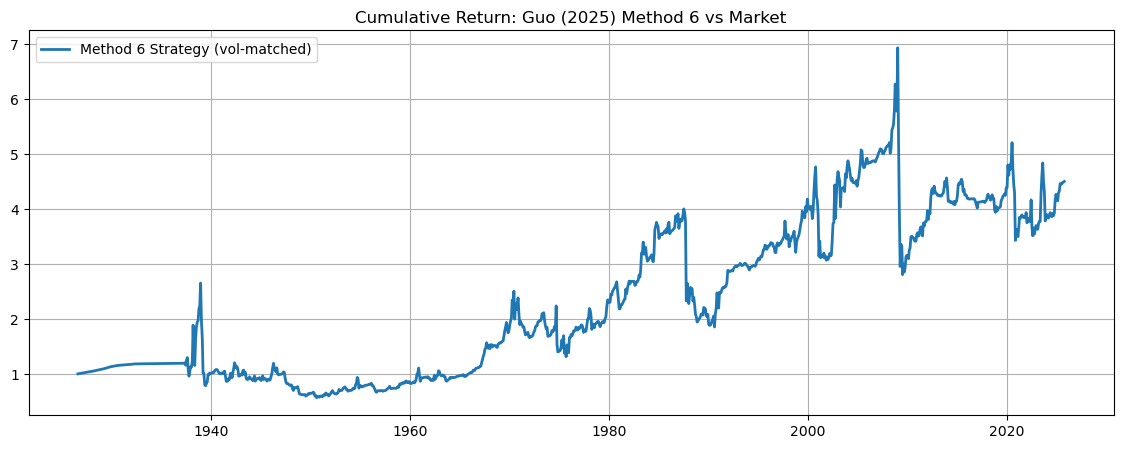

In [6]:
def plot_method6_performance(res):
    strat_wealth = (1.0 + res["strat_total"]).dropna().cumprod()
    mkt_wealth = (1.0 + res["mkt_total"]).reindex(strat_wealth.index).cumprod()

    plt.figure(figsize=(14, 5))
    plt.plot(strat_wealth, label="Method 6 Strategy (vol-matched)", linewidth=2)
    #plt.plot(mkt_wealth, label="Market", linestyle="--", linewidth=1.5)
    plt.title("Cumulative Return: Guo (2025) Method 6 vs Market")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_method6_performance(res_m6)


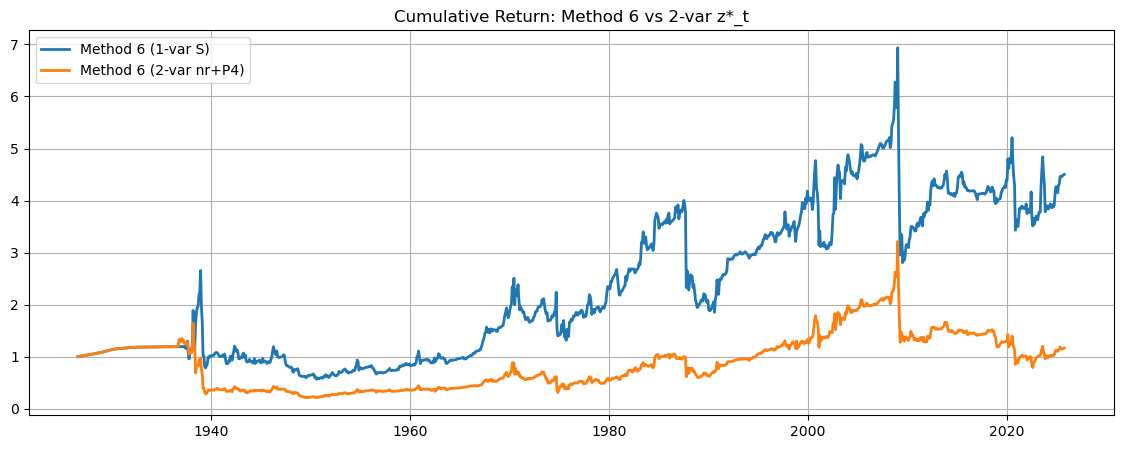

[Method 6 (1-var S)]
Period: 1926-08 〜 2025-10
 Strategy:  mu=3.27%, sigma=18.41%, Sharpe=0.18
 Market  :  mu=11.53%, sigma=18.37%, Sharpe=0.63

[Method 6 (2-var nr+P4)]
Period: 1926-08 〜 2025-10
 Strategy:  mu=2.01%, sigma=18.44%, Sharpe=0.11
 Market  :  mu=11.53%, sigma=18.37%, Sharpe=0.63

[Method 6 (1-var S, 2020+)]
Period: 2020-01 〜 2025-10
 Strategy:  mu=1.98%, sigma=17.37%, Sharpe=0.11
 Market  :  mu=15.87%, sigma=18.04%, Sharpe=0.88

[Method 6 (2-var nr+P4, 2020+)]
Period: 2020-01 〜 2025-10
 Strategy:  mu=0.52%, sigma=20.70%, Sharpe=0.03
 Market  :  mu=15.87%, sigma=18.04%, Sharpe=0.88



In [8]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import statsmodels.api as sm


# 既存：Ken French 元ファイルから月次部分だけ抽出
def load_ff_monthly_from_ken_french(csv_path: str) -> pd.DataFrame:
    raw = pd.read_csv(csv_path, skiprows=4)

    num = pd.to_numeric(raw['Unnamed: 0'], errors='coerce')
    mask_monthly = num > 10000
    monthly = raw[mask_monthly].copy()

    monthly = monthly.rename(columns={'Unnamed: 0': 'date'})
    monthly['date'] = pd.to_datetime(monthly['date'].astype(int), format="%Y%m")
    monthly = monthly.set_index('date').sort_index()

    for col in ['Mkt-RF', 'RF']:
        monthly[col] = pd.to_numeric(monthly[col], errors='coerce')

    ff = monthly[['Mkt-RF', 'RF']].copy()
    ff['mkt_excess'] = ff['Mkt-RF'] / 100.0
    ff['rf']         = ff['RF'] / 100.0

    return ff[['mkt_excess', 'rf']].dropna()


# 既存：Guo の月タイプ分類
def classify_month_type(index):
    mt = pd.Series(index=index, dtype="object")
    for t in index:
        m = t.month % 3
        if m == 1:
            mt[t] = 'N'   # newsy
        elif m == 2:
            mt[t] = 'R'   # repetitive
        else:
            mt[t] = '3'   # 3rd month
    return mt


# nr(t) と nm4 (P4) を計算
def add_nr_and_nm4(ff: pd.DataFrame) -> pd.DataFrame:
    """
    ff: load_ff_monthly_from_ken_french の出力
        必須列: ['mkt_excess', 'rf']

    戻り値:
        ff に以下の列を追加した DataFrame:
          - 'month_type' : 'N', 'R', '3'
          - 'mkt_nr'     : nr(t) 用の市場超過リターン
          - 'mkt_nm1'..'mkt_nm4'
          - 'mkt_nm4_avg': 過去4つ newsy 月リターンの平均 (P4)
    """
    df = ff.copy()
    df["month_type"] = classify_month_type(df.index)

    dates = list(df.index)
    mt = df["month_type"].values
    mkt = df["mkt_excess"].values

    nr_dates = []
    mkt_nr_list = []

    past_newsy_indices = []
    mkt_nm1 = []
    mkt_nm2 = []
    mkt_nm3 = []
    mkt_nm4 = []

    for i, t in enumerate(dates):
        # nr(t): t より前で最も近い N or R
        nr_idx = None
        j = i - 1
        while j >= 0:
            if mt[j] in ("N", "R"):
                nr_idx = j
                break
            j -= 1
        if nr_idx is None:
            nr_dates.append(None)
            mkt_nr_list.append(np.nan)
        else:
            nr_dates.append(dates[nr_idx])
            mkt_nr_list.append(mkt[nr_idx])

        # newsy 月の履歴更新
        if mt[i] == "N":
            past_newsy_indices.append(i)

        # nm(t,j): 直近の newsy 月たち
        cand = [k for k in past_newsy_indices if k < i]
        cand = sorted(cand, reverse=True)

        vals = []
        for jj in range(4):
            if jj < len(cand):
                vals.append(mkt[cand[jj]])
            else:
                vals.append(np.nan)

        mkt_nm1.append(vals[0])
        mkt_nm2.append(vals[1])
        mkt_nm3.append(vals[2])
        mkt_nm4.append(vals[3])

    df["nr_date"]   = nr_dates
    df["mkt_nr"]    = mkt_nr_list
    df["mkt_nm1"]   = mkt_nm1
    df["mkt_nm2"]   = mkt_nm2
    df["mkt_nm3"]   = mkt_nm3
    df["mkt_nm4"]   = mkt_nm4
    df["mkt_nm4_avg"] = df[["mkt_nm1", "mkt_nm2", "mkt_nm3", "mkt_nm4"]].mean(axis=1)

    return df

def build_nr_p4_signals(df_nr_p4: pd.DataFrame):
    """
    df_nr_p4: add_nr_and_nm4(ff) を通した DataFrame
              必須列: 'mkt_nr', 'mkt_nm4_avg', 'month_type'

    戻り値:
        x1, x2, month_type
        x1_t, x2_t は「t のリターンを予測するために t-1 までの情報から構成したシグナル」
    """
    df = df_nr_p4.copy()
    idx = df.index
    month_type = df["month_type"]
    is_newsy = (month_type == "N")

    mkt_nr = df["mkt_nr"]
    P4     = df["mkt_nm4_avg"]

    x1 = pd.Series(index=idx, dtype=float)  # nr 用
    x2 = pd.Series(index=idx, dtype=float)  # P4 用

    hist_nr = []
    hist_P4 = []

    # t=1 以降について、t-1 の情報で x_t を構築
    for i in range(1, len(idx)):
        prev_date = idx[i-1]   # t-1
        curr_date = idx[i]     # t

        nr_prev = mkt_nr.loc[prev_date]
        P4_prev = P4.loc[prev_date]

        # nr/P4 のどちらかが NaN ならシグナルは NaN
        if np.isnan(nr_prev) or np.isnan(P4_prev):
            x1[curr_date] = np.nan
            x2[curr_date] = np.nan
            continue

        # これまでの履歴＋直近値までで平均を計算
        hist_nr.append(nr_prev)
        hist_P4.append(P4_prev)
        nr_bar = float(np.mean(hist_nr))
        P4_bar = float(np.mean(hist_P4))

        nr_dm = nr_prev - nr_bar
        P4_dm = P4_prev - P4_bar

        # 翌月 t が newsy なら符号反転
        sign = -1.0 if is_newsy[curr_date] else 1.0

        x1[curr_date] = sign * nr_dm
        x2[curr_date] = sign * P4_dm

    return x1, x2, month_type

def backtest_method6_zstar_strategy(
    ff: pd.DataFrame,
    min_obs: int = 120,
    target_vol: float = None,
    max_leverage: float = None,
) -> pd.DataFrame:
    """
    Guo (2025) Method 6 を nr + P4 の 2変数版に拡張した戦略。

    ff: load_ff_monthly_from_ken_french の出力
        必須列: 'mkt_excess', 'rf'

    戻り値:
        DataFrame:
          - mkt_excess, rf, mkt_total
          - month_type
          - x1_nr, x2_P4
          - mkt_mean
          - beta1, beta2
          - w_raw, exp_ret
          - strat_excess_raw, strat_excess_scaled, strat_total
    """
    # 0) 基本の市場リターン
    mkt_excess = ff["mkt_excess"].copy()
    rf         = ff["rf"].copy()
    mkt_total  = mkt_excess + rf
    idx        = mkt_total.index

    # 1) nr, P4 を計算
    df_nr_p4 = add_nr_and_nm4(ff)

    # 2) nr, P4 から x1_t, x2_t を構築（Method 6 と同じロジック）
    x1, x2, month_type = build_nr_p4_signals(df_nr_p4)

    # 3) mkt̄_{t-1}（expanding mean を1期シフト）
    mkt_mean = mkt_total.expanding().mean().shift(1)

    # 4) 回帰 (mkt_t - mkt̄_{t-1}) = β1 x1_t + β2 x2_t
    y_adj = mkt_total - mkt_mean
    beta1 = pd.Series(index=idx, dtype=float)
    beta2 = pd.Series(index=idx, dtype=float)

    for i, t in enumerate(idx):
        mask = (idx <= t) & x1.notna() & x2.notna() & y_adj.notna()
        n = mask.sum()
        if n < min_obs:
            beta1[t] = np.nan
            beta2[t] = np.nan
            continue

        X = np.column_stack([x1[mask].values, x2[mask].values])
        y = y_adj[mask].values

        # OLS: β = (X'X)^(-1) X'y （2変数なので自前実装でもOK）
        XtX = X.T @ X
        XtY = X.T @ y
        try:
            beta_vec = np.linalg.solve(XtX, XtY)
            beta1[t], beta2[t] = beta_vec[0], beta_vec[1]
        except np.linalg.LinAlgError:
            beta1[t], beta2[t] = np.nan, np.nan

    # 5) 1ヶ月先の予測と weight（β_t を t->t+1 に使う）
    exp_ret = pd.Series(index=idx, dtype=float)
    w_raw   = pd.Series(index=idx, dtype=float)

    for i in range(len(idx) - 1):
        t      = idx[i]
        t_next = idx[i + 1]

        b1 = beta1[t]
        b2 = beta2[t]
        xt1 = x1[t]
        xt2 = x2[t]
        mt_bar = mkt_mean[t]

        if any(np.isnan([b1, b2, xt1, xt2, mt_bar])):
            exp_ret[t_next] = np.nan
            w = 0.0
        else:
            w = b1 * xt1 + b2 * xt2
            if max_leverage is not None:
                w = float(np.clip(w, -max_leverage, max_leverage))

            exp_ret[t_next] = w + mt_bar

        w_raw[t_next] = w

    # 6) overlay の超過リターン
    strat_excess_raw = w_raw * mkt_excess

    # 7) ボラ調整（Sharpe 比比較のため）
    common_mask = strat_excess_raw.notna() & mkt_excess.notna()
    strat_vol   = strat_excess_raw[common_mask].std(ddof=1)
    mkt_vol     = mkt_excess[common_mask].std(ddof=1)

    if target_vol is None:
        target_vol = float(mkt_vol)  # 市場ボラに合わせる

    if strat_vol is not None and strat_vol > 0:
        scale = target_vol / strat_vol
    else:
        scale = 1.0

    strat_excess_scaled = strat_excess_raw * scale
    strat_total         = rf + strat_excess_scaled

    out = pd.DataFrame({
        "mkt_excess": mkt_excess,
        "rf": rf,
        "mkt_total": mkt_total,
        "month_type": month_type,
        "x1_nr": x1,
        "x2_P4": x2,
        "mkt_mean": mkt_mean,
        "beta1": beta1,
        "beta2": beta2,
        "w_raw": w_raw,
        "exp_ret": exp_ret,
        "strat_excess_raw": strat_excess_raw,
        "strat_excess_scaled": strat_excess_scaled,
        "strat_total": strat_total,
    })
    out.attrs["scale"]       = scale
    out.attrs["target_vol"]  = target_vol
    out.attrs["min_obs"]     = min_obs
    out.attrs["max_leverage"] = max_leverage

    return out

def plot_cumret(res, label, ax=None):
    strat_wealth = (1.0 + res["strat_total"]).dropna().cumprod()
    mkt_wealth   = (1.0 + res["mkt_total"]).reindex(strat_wealth.index).cumprod()

    if ax is None:
        fig, ax = plt.subplots(figsize=(14,5))

    ax.plot(strat_wealth, label=label, linewidth=2)
    #ax.plot(mkt_wealth,   label="Market", linestyle="--", linewidth=1.5)
    ax.grid(True)
    ax.legend()
    return ax

def summarize(res, label, start=None, end=None):
    if start is not None or end is not None:
        sub = res.loc[start:end].copy()
    else:
        sub = res.copy()

    strat = sub["strat_total"].dropna()
    mkt   = sub["mkt_total"].reindex(strat.index)

    def ann_stats(r):
        mu_m = r.mean()
        sd_m = r.std(ddof=1)
        mu_a = mu_m * 12
        sd_a = sd_m * math.sqrt(12)
        sharpe = mu_a / sd_a if sd_a > 0 else np.nan
        return mu_a, sd_a, sharpe

    mu_s, sd_s, sh_s     = ann_stats(strat)
    mu_mkt, sd_mkt, sh_m = ann_stats(mkt)

    print(f"[{label}]")
    print("Period:", strat.index[0].strftime("%Y-%m"), "〜", strat.index[-1].strftime("%Y-%m"))
    print(" Strategy:  mu={:.2%}, sigma={:.2%}, Sharpe={:.2f}".format(mu_s, sd_s, sh_s))
    print(" Market  :  mu={:.2%}, sigma={:.2%}, Sharpe={:.2f}".format(mu_mkt, sd_mkt, sh_m))
    print()


if __name__ == "__main__":
    ff = load_ff_monthly_from_ken_french("F-F_Research_Data_Factors.csv")

    # 1) Guo 推奨の Method 6 1変数版（前回の backtest_method6_strategy がある前提）
    res_m6_1 = backtest_method6_strategy(ff, min_obs=120, target_vol=None, max_leverage=None)

    # 2) nr + P4 の 2変数版 z*_t
    res_m6_2 = backtest_method6_zstar_strategy(ff, min_obs=120, target_vol=None, max_leverage=None)

    # 3) フルサンプルの累積リターン比較
    fig, ax = plt.subplots(figsize=(14,5))
    plot_cumret(res_m6_1, "Method 6 (1-var S)", ax=ax)
    plot_cumret(res_m6_2, "Method 6 (2-var nr+P4)", ax=ax)
    ax.set_title("Cumulative Return: Method 6 vs 2-var z*_t")
    plt.show()

    # 4) サマリ統計（全期間 & 2020年以降）
    summarize(res_m6_1, "Method 6 (1-var S)")
    summarize(res_m6_2, "Method 6 (2-var nr+P4)")
    summarize(res_m6_1, "Method 6 (1-var S, 2020+)", start="2020-01-01")
    summarize(res_m6_2, "Method 6 (2-var nr+P4, 2020+)", start="2020-01-01")


########## Table 4 Methods (M0〜M6) OOS 比較: 1926–2025 ##########


/var/folders/3n/5qpgng455w713g5kj65vkyq80000gn/T/ipykernel_92982/1467441021.py:272: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_hat[t_next] = float(X_next_const @ model.params.values)
/var/folders/3n/5qpgng455w713g5kj65vkyq80000gn/T/ipykernel_92982/1467441021.py:272: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_hat[t_next] = float(X_next_const @ model.params.values)
/var/folders/3n/5qpgng455w713g5kj65vkyq80000gn/T/ipykernel_92982/1467441021.py:272: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this o

=== OOS Performance (1926-07〜2025-10) ===
Baseline Market (Buy&Hold, Excess):
  mu=8.32%, sigma=18.40%, Sharpe=0.45

[M0_mean]
  mu=7.45%, sigma=14.98%, Sharpe=0.50, OOS R^2=0.009

[M1_AR1]
  mu=4.73%, sigma=15.06%, Sharpe=0.31, OOS R^2=-0.002

[M2_NR]
  mu=7.39%, sigma=14.97%, Sharpe=0.49, OOS R^2=0.008

[M3_P4]
  mu=5.01%, sigma=15.05%, Sharpe=0.33, OOS R^2=-0.006

[M4_NR_P4]
  mu=5.50%, sigma=15.04%, Sharpe=0.37, OOS R^2=-0.017

[M6_S]
  mu=3.73%, sigma=15.04%, Sharpe=0.25, OOS R^2=-0.060

########## Table 4 Methods OOS 比較: 2020+ ##########
=== OOS Performance (2020-01〜2025-10) ===
Baseline Market (Buy&Hold, Excess):
  mu=13.24%, sigma=18.03%, Sharpe=0.73

[M0_mean]
  mu=0.00%, sigma=0.00%, Sharpe=nan, OOS R^2=nan

[M1_AR1]
  mu=0.00%, sigma=0.00%, Sharpe=nan, OOS R^2=nan

[M2_NR]
  mu=0.00%, sigma=0.00%, Sharpe=nan, OOS R^2=nan

[M3_P4]
  mu=0.00%, sigma=0.00%, Sharpe=nan, OOS R^2=nan

[M4_NR_P4]
  mu=0.00%, sigma=0.00%, Sharpe=nan, OOS R^2=nan

[M6_S]
  mu=0.00%, sigma=0.00%, Shar

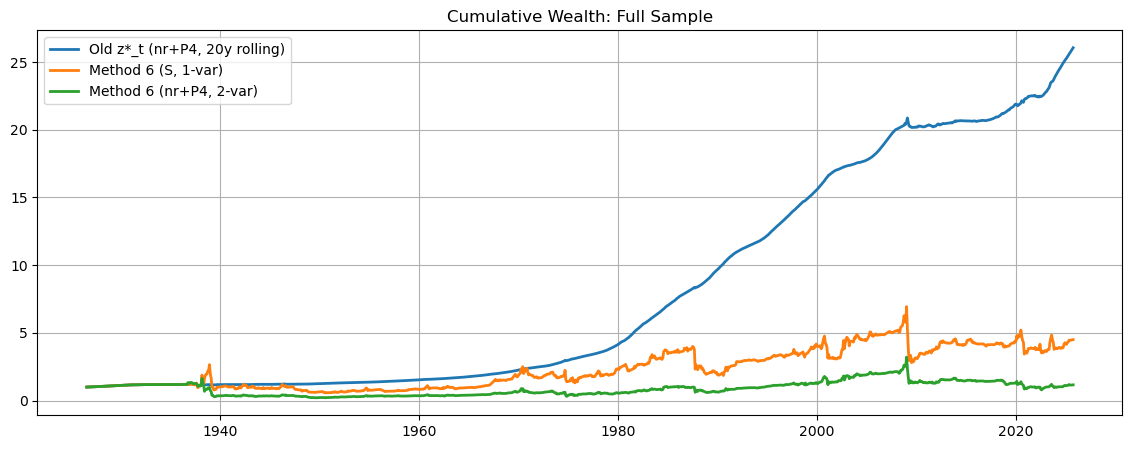

########## 3戦略比較: 2020+ ##########
[Old z*_t (nr+P4, 20y rolling)] Period: 2020-01 〜 2025-10
  Strategy: mu=3.01%, sigma=0.91%, Sharpe=3.32
  Market  : mu=15.87%, sigma=18.04%, Sharpe=0.88

[Method 6 (S, 1-var)] Period: 2020-01 〜 2025-10
  Strategy: mu=1.98%, sigma=17.37%, Sharpe=0.11
  Market  : mu=15.87%, sigma=18.04%, Sharpe=0.88

[Method 6 (nr+P4, 2-var)] Period: 2020-01 〜 2025-10
  Strategy: mu=0.52%, sigma=20.70%, Sharpe=0.03
  Market  : mu=15.87%, sigma=18.04%, Sharpe=0.88



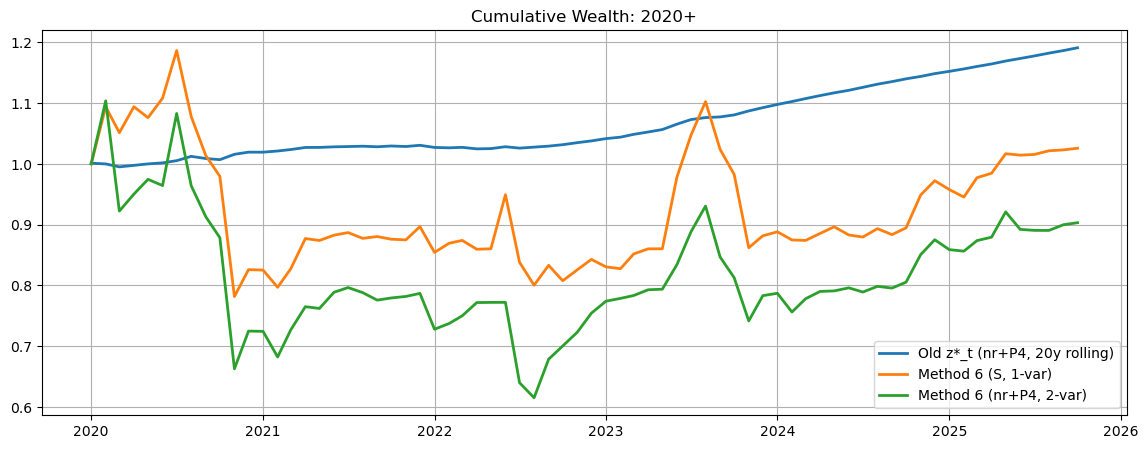

In [10]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import statsmodels.api as sm


# ======================================================================
# 1. Ken French 読み込み & 月タイプ分類
# ======================================================================

def load_ff_monthly_from_ken_french(csv_path: str) -> pd.DataFrame:
    """
    Ken French の F-F_Research_Data_Factors.csv から
    月次 Mkt-RF, RF を抜き出し、リターンレベルに変換する。
    """
    raw = pd.read_csv(csv_path, skiprows=4)

    num = pd.to_numeric(raw['Unnamed: 0'], errors='coerce')
    mask_monthly = num > 10000  # YYYYMM 部分だけ抽出
    monthly = raw[mask_monthly].copy()

    monthly = monthly.rename(columns={'Unnamed: 0': 'date'})
    monthly['date'] = pd.to_datetime(monthly['date'].astype(int), format="%Y%m")
    monthly = monthly.set_index('date').sort_index()

    for col in ['Mkt-RF', 'RF']:
        monthly[col] = pd.to_numeric(monthly[col], errors='coerce')

    ff = monthly[['Mkt-RF', 'RF']].copy()
    ff['mkt_excess'] = ff['Mkt-RF'] / 100.0
    ff['rf']         = ff['RF'] / 100.0

    return ff[['mkt_excess', 'rf']].dropna()


def classify_month_type(index: pd.DatetimeIndex) -> pd.Series:
    """
    Guo に合わせた月タイプ分類：
      - N: 四半期1ヶ月目 (1,4,7,10月など)
      - R: 四半期2ヶ月目
      - 3: 四半期3ヶ月目
    """
    mt = pd.Series(index=index, dtype="object")
    for t in index:
        m = t.month % 3
        if m == 1:
            mt[t] = 'N'
        elif m == 2:
            mt[t] = 'R'
        else:
            mt[t] = '3'
    return mt


# ======================================================================
# 2. nr, P4, Method 6 用シグナル
# ======================================================================

def add_nr_and_p4(ff: pd.DataFrame) -> pd.DataFrame:
    """
    ff: 必須列 'mkt_excess', 'rf'

    追加列:
      - month_type   : 'N','R','3'
      - mkt_nr       : 直近の N/R 月の超過リターン (nr)
      - mkt_nm1..4   : 過去 j 番目の N 月 (超過リターン)
      - P4           : mkt_nm1..4 の平均 (Parameter-Compression 用)
      - mkt_nm4_avg  : P4 と同じ (別名。z*_t 旧実装互換用)
    """
    df = ff.copy()
    df["month_type"] = classify_month_type(df.index)

    dates = df.index.to_list()
    mt = df["month_type"].values
    mkt = df["mkt_excess"].values

    nr_dates = []
    mkt_nr_list = []

    past_newsy_indices = []
    mkt_nm1 = []
    mkt_nm2 = []
    mkt_nm3 = []
    mkt_nm4 = []

    for i, t in enumerate(dates):
        # nr(t): t より前で最も近い N or R
        nr_idx = None
        j = i - 1
        while j >= 0:
            if mt[j] in ("N", "R"):
                nr_idx = j
                break
            j -= 1
        if nr_idx is None:
            nr_dates.append(None)
            mkt_nr_list.append(np.nan)
        else:
            nr_dates.append(dates[nr_idx])
            mkt_nr_list.append(mkt[nr_idx])

        # newsy 月履歴更新
        if mt[i] == "N":
            past_newsy_indices.append(i)

        # nm(t,j): 直近の newsy 月たち
        cand = [k for k in past_newsy_indices if k < i]
        cand = sorted(cand, reverse=True)

        vals = []
        for jj in range(4):
            if jj < len(cand):
                vals.append(mkt[cand[jj]])
            else:
                vals.append(np.nan)

        mkt_nm1.append(vals[0])
        mkt_nm2.append(vals[1])
        mkt_nm3.append(vals[2])
        mkt_nm4.append(vals[3])

    df["nr_date"] = nr_dates
    df["mkt_nr"]  = mkt_nr_list
    df["mkt_nm1"] = mkt_nm1
    df["mkt_nm2"] = mkt_nm2
    df["mkt_nm3"] = mkt_nm3
    df["mkt_nm4"] = mkt_nm4

    df["P4"] = df[["mkt_nm1", "mkt_nm2", "mkt_nm3", "mkt_nm4"]].mean(axis=1)
    df["mkt_nm4_avg"] = df["P4"]  # 旧実装互換用

    return df


def compute_S_and_x_for_method6(mkt_total: pd.Series):
    """
    Method 6 用:
      - S_t: t までに出現した直近4つの newsy 月 total return の合計
      - x_t: S_{t-1} を expanding 平均で demean し、翌月 t が newsy なら sign flip
    """
    idx = mkt_total.index
    month_type = classify_month_type(idx)
    is_newsy = (month_type == "N")

    news_series = mkt_total[is_newsy]

    S = pd.Series(index=idx, dtype=float)
    for t in idx:
        past = news_series[news_series.index <= t]
        if len(past) >= 4:
            S[t] = past.iloc[-4:].sum()
        else:
            S[t] = np.nan

    x = pd.Series(index=idx, dtype=float)
    S_hist = []

    for i in range(1, len(idx)):
        prev_date = idx[i-1]   # t-1
        curr_date = idx[i]     # t

        s_prev = S.loc[prev_date]
        if np.isnan(s_prev):
            x[curr_date] = np.nan
            continue

        S_hist.append(s_prev)
        s_bar = float(np.mean(S_hist))

        sign = -1.0 if is_newsy[curr_date] else 1.0
        x[curr_date] = sign * (s_prev - s_bar)

    return S, x, month_type


def build_nr_p4_signals(df_nr_p4: pd.DataFrame):
    """
    nr + P4 を Method 6 と同じロジック（demean + sign flip）で x1,x2 に変換。
    x1_t, x2_t は「t のリターン予測に使うシグナル」。
    """
    df = df_nr_p4.copy()
    idx = df.index
    month_type = df["month_type"]
    is_newsy = (month_type == "N")

    mkt_nr = df["mkt_nr"]
    P4     = df["mkt_nm4_avg"]

    x1 = pd.Series(index=idx, dtype=float)
    x2 = pd.Series(index=idx, dtype=float)

    hist_nr = []
    hist_P4 = []

    for i in range(1, len(idx)):
        prev_date = idx[i-1]
        curr_date = idx[i]

        nr_prev = mkt_nr.loc[prev_date]
        P4_prev = P4.loc[prev_date]

        if np.isnan(nr_prev) or np.isnan(P4_prev):
            x1[curr_date] = np.nan
            x2[curr_date] = np.nan
            continue

        hist_nr.append(nr_prev)
        hist_P4.append(P4_prev)
        nr_bar = float(np.mean(hist_nr))
        P4_bar = float(np.mean(hist_P4))

        nr_dm = nr_prev - nr_bar
        P4_dm = P4_prev - P4_bar

        sign = -1.0 if is_newsy[curr_date] else 1.0
        x1[curr_date] = sign * nr_dm
        x2[curr_date] = sign * P4_dm

    return x1, x2, month_type


# ======================================================================
# 3. compare_all_methods 用：OOS 回帰 & Sign 戦略
# ======================================================================

def oos_linear_forecast_sign_strategy(
    y: pd.Series,
    X: pd.DataFrame,
    min_obs: int = 120
):
    """
    y: 目的変数 (mkt_excess など)
    X: 説明変数（列ベクトル1本でも複数でも可）
    min_obs: OLS を回す最小観測数

    戻り値:
      - y_hat: OOS 予測
      - w_sign: sign 戦略のウェイト (+1/ -1 / 0)
      - strat_excess: sign 戦略の超過リターン
      - coefs: 各 t の係数 (DataFrame)
    """
    idx = y.index
    X = X.copy().reindex(idx)

    coefs = pd.DataFrame(index=idx, columns=["const"] + list(X.columns), dtype=float)
    y_hat = pd.Series(index=idx, dtype=float)

    for i in range(len(idx) - 1):
        t = idx[i]
        t_next = idx[i+1]

        mask = (idx <= t) & y.notna()
        for col in X.columns:
            mask &= X[col].notna()
        n = mask.sum()
        if n < min_obs:
            y_hat[t_next] = np.nan
            continue

        Xi = X.loc[mask]
        yi = y.loc[mask]
        Xi_const = sm.add_constant(Xi)
        model = sm.OLS(yi, Xi_const).fit()

        coefs.loc[t, "const"] = model.params.get("const", np.nan)
        for col in X.columns:
            coefs.loc[t, col] = model.params.get(col, np.nan)

        x_next = X.loc[t, :].values.reshape(1, -1)
        X_next_const = np.concatenate([np.array([[1.0]]), x_next], axis=1)
        y_hat[t_next] = float(X_next_const @ model.params.values)

    w_sign = np.sign(y_hat).fillna(0.0)
    strat_excess = w_sign * y

    return y_hat, w_sign, strat_excess, coefs


def run_method0_mean(ff: pd.DataFrame, min_obs: int = 120):
    """
    Method 0 的なベースライン：過去平均で OOS 予測
    """
    y = ff["mkt_excess"].copy()
    idx = y.index

    y_hat = pd.Series(index=idx, dtype=float)
    for i in range(len(idx) - 1):
        t = idx[i]
        t_next = idx[i+1]
        past = y.iloc[: i+1].dropna()
        if len(past) < min_obs:
            y_hat[t_next] = np.nan
        else:
            y_hat[t_next] = past.mean()

    w_sign = np.sign(y_hat).fillna(0.0)
    strat_excess = w_sign * y

    return y_hat, w_sign, strat_excess


def run_method1_ar1(ff: pd.DataFrame, min_obs: int = 120):
    y = ff["mkt_excess"].copy()
    X = pd.DataFrame({"mkt_lag": ff["mkt_excess"].shift(1)})
    return oos_linear_forecast_sign_strategy(y, X, min_obs=min_obs)


def run_method2_nr(ff: pd.DataFrame, min_obs: int = 120):
    y = ff["mkt_excess"].copy()
    X = pd.DataFrame({"mkt_nr": ff["mkt_nr"]})
    return oos_linear_forecast_sign_strategy(y, X, min_obs=min_obs)


def run_method3_p4(ff: pd.DataFrame, min_obs: int = 120):
    y = ff["mkt_excess"].copy()
    X = pd.DataFrame({"P4": ff["P4"]})
    return oos_linear_forecast_sign_strategy(y, X, min_obs=min_obs)


def run_method4_nr_p4(ff: pd.DataFrame, min_obs: int = 120):
    y = ff["mkt_excess"].copy()
    X = pd.DataFrame({
        "mkt_nr": ff["mkt_nr"],
        "P4":     ff["P4"]
    })
    return oos_linear_forecast_sign_strategy(y, X, min_obs=min_obs)


def run_method6_S(ff: pd.DataFrame, min_obs: int = 120):
    """
    Method 6 の x_M6（S の demean+sign flip）を説明変数にした簡易版。
    目的変数は mkt_excess に統一。
    """
    y = ff["mkt_excess"].copy()
    X = pd.DataFrame({"x_M6": ff["x_M6"]})
    return oos_linear_forecast_sign_strategy(y, X, min_obs=min_obs)


def annualized_stats(r: pd.Series):
    r = r.dropna()
    mu_m = r.mean()
    sd_m = r.std(ddof=1)
    mu_a = mu_m * 12
    sd_a = sd_m * math.sqrt(12)
    sharpe = mu_a / sd_a if sd_a > 0 else np.nan
    return mu_a, sd_a, sharpe


def compute_oos_r2(y: pd.Series, y_hat: pd.Series):
    """
    OOS R^2：OOS 平均予測に対する相対改善度
    """
    mask = y.notna() & y_hat.notna()
    y_ = y[mask]
    yhat_ = y_hat[mask]
    if len(y_) == 0:
        return np.nan

    mean_hat = pd.Series(index=y_.index, dtype=float)
    for i, t in enumerate(y_.index):
        past = y_.iloc[:i]
        if len(past) == 0:
            mean_hat[t] = np.nan
        else:
            mean_hat[t] = past.mean()

    mask2 = mean_hat.notna()
    y_ = y_[mask2]
    yhat_ = yhat_[mask2]
    mean_hat = mean_hat[mask2]

    num = ((y_ - yhat_)**2).sum()
    den = ((y_ - mean_hat)**2).sum()
    return 1.0 - num / den if den > 0 else np.nan


def compare_all_methods(csv_path: str, min_obs: int = 120, start=None, end=None):
    """
    M0〜M6 の OOS 予測・Sign 戦略を一括比較。
    """
    ff = load_ff_monthly_from_ken_french(csv_path)
    ff = add_nr_and_p4(ff)
    ff["mkt_total"] = ff["mkt_excess"] + ff["rf"]
    S, x_M6, mt = compute_S_and_x_for_method6(ff["mkt_total"])
    ff["S_M6"] = S
    ff["x_M6"] = x_M6
    ff["mt"]   = mt

    if start is not None or end is not None:
        ff = ff.loc[start:end].copy()

    results = {}

    # M0: mean
    y_hat0, w0, strat0 = run_method0_mean(ff, min_obs=min_obs)
    results["M0_mean"] = (y_hat0, strat0)

    # M1: AR(1)
    y_hat1, w1, strat1, coef1 = run_method1_ar1(ff, min_obs=min_obs)
    results["M1_AR1"] = (y_hat1, strat1)

    # M2: nr only
    y_hat2, w2, strat2, coef2 = run_method2_nr(ff, min_obs=min_obs)
    results["M2_NR"] = (y_hat2, strat2)

    # M3: P4 only
    y_hat3, w3, strat3, coef3 = run_method3_p4(ff, min_obs=min_obs)
    results["M3_P4"] = (y_hat3, strat3)

    # M4: nr+P4
    y_hat4, w4, strat4, coef4 = run_method4_nr_p4(ff, min_obs=min_obs)
    results["M4_NR_P4"] = (y_hat4, strat4)

    # M6: S (x_M6)
    y_hat6, w6, strat6, coef6 = run_method6_S(ff, min_obs=min_obs)
    results["M6_S"] = (y_hat6, strat6)

    y = ff["mkt_excess"]

    print("=== OOS Performance ({}〜{}) ===".format(ff.index[0].strftime("%Y-%m"),
                                                  ff.index[-1].strftime("%Y-%m")))
    print("Baseline Market (Buy&Hold, Excess):")
    mu_mkt, sd_mkt, sh_mkt = annualized_stats(y)
    print("  mu={:.2%}, sigma={:.2%}, Sharpe={:.2f}".format(mu_mkt, sd_mkt, sh_mkt))
    print()

    for name, (y_hat, strat) in results.items():
        mu_s, sd_s, sh_s = annualized_stats(strat)
        r2 = compute_oos_r2(y, y_hat)
        print(f"[{name}]")
        print("  mu={:.2%}, sigma={:.2%}, Sharpe={:.2f}, OOS R^2={:.3f}".format(mu_s, sd_s, sh_s, r2))
        print()

    return ff, results


# ======================================================================
# 4. 旧 z*_t 戦略用：apply_timing_strategy + build_z_star_online
# ======================================================================

def apply_timing_strategy(df, target_vol=0.05, max_leverage=3.0):
    """
    df['z'] をシグナルとしてボラターゲットする戦略。
    （もともとお使いだった実装をベースに）
    """
    out = df.copy()
    z = out["z"]

    weights = []
    sig_hist = []
    strat_excess = []
    strat_total = []
    mkt_total = []

    for i, t in enumerate(out.index):
        if i == 0:
            sigma = np.nan
            w = 0.0
        else:
            sigma = z.iloc[:i].std(ddof=1)
            if np.isnan(sigma) or sigma == 0:
                w = 0.0
            else:
                w = z.iloc[i] * target_vol / sigma
                w = float(np.clip(w, -max_leverage, max_leverage))

        weights.append(w)
        sig_hist.append(sigma)

        mkt = out.at[t, "mkt_excess"]
        rf  = out.at[t, "rf"]
        se  = w * mkt
        strat_excess.append(se)
        strat_total.append(rf + se)
        mkt_total.append(rf + mkt)

    out["w"]            = weights
    out["sigma_z_hist"] = sig_hist
    out["strat_excess"] = strat_excess
    out["strat_total"]  = strat_total
    out["mkt_total"]    = mkt_total

    return out


def build_z_star_online(
    ff: pd.DataFrame,
    lookback_years: int = 20,
    min_obs: int = 120,
) -> pd.DataFrame:
    """
    旧 z*_t 戦略用のオンライン係数推定：
    - y: mkt_excess
    - X: [mkt_nr, mkt_nm4_avg]（同時点）
    - t-1 時点までの直近 lookback_years 年で OLS
    """
    df = add_nr_and_p4(ff)
    df["mkt_total"] = df["mkt_excess"] + df["rf"]

    idx = df.index
    beta1 = pd.Series(index=idx, dtype=float)
    beta2 = pd.Series(index=idx, dtype=float)

    for i, t in enumerate(idx):
        if i == 0:
            continue

        end_date = idx[i-1]
        start_date = end_date - pd.DateOffset(years=lookback_years)

        mask = (idx >= start_date) & (idx <= end_date)
        sub = df.loc[mask, ["mkt_excess", "mkt_nr", "mkt_nm4_avg"]].dropna()

        if len(sub) < min_obs:
            continue

        y = sub["mkt_excess"]
        X = sub[["mkt_nr", "mkt_nm4_avg"]]
        X_const = sm.add_constant(X)

        model = sm.OLS(y, X_const).fit()

        beta1[t] = model.params.get("mkt_nr", np.nan)
        beta2[t] = model.params.get("mkt_nm4_avg", np.nan)

    df["beta_nr"]  = beta1
    df["beta_P4"]  = beta2
    df["z_star"]   = df["beta_nr"] * df["mkt_nr"] + df["beta_P4"] * df["mkt_nm4_avg"]

    return df


# ======================================================================
# 5. Method 6（1変数 & nr+P4 2変数）戦略
# ======================================================================

def backtest_method6_strategy(ff: pd.DataFrame,
                              min_obs: int = 120,
                              target_vol: float = None,
                              max_leverage: float = None) -> pd.DataFrame:
    """
    Guo (2025) Method 6: S (4 newsy sum) → x_t → β_t x_t による time-series strategy
    mkt_total, mkt_mean を使った忠実版。
    """
    mkt_excess = ff["mkt_excess"].copy()
    rf         = ff["rf"].copy()
    mkt_total  = mkt_excess + rf
    idx        = mkt_total.index

    S, x, month_type = compute_S_and_x_for_method6(mkt_total)
    mkt_mean = mkt_total.expanding().mean().shift(1)

    y_adj = mkt_total - mkt_mean
    beta = pd.Series(index=idx, dtype=float)

    for i, t in enumerate(idx):
        mask = (idx <= t) & x.notna() & y_adj.notna()
        n = mask.sum()
        if n < min_obs:
            beta[t] = np.nan
            continue

        xi = x[mask].values
        yi = y_adj[mask].values
        denom = (xi ** 2).sum()
        beta[t] = (xi * yi).sum() / denom if denom > 0 else np.nan

    exp_ret = pd.Series(index=idx, dtype=float)
    w_raw   = pd.Series(index=idx, dtype=float)

    for i in range(len(idx) - 1):
        t      = idx[i]
        t_next = idx[i + 1]

        if any(np.isnan([beta[t], x[t], mkt_mean[t]])):
            exp_ret[t_next] = np.nan
            w = 0.0
        else:
            w = beta[t] * x[t]
            if max_leverage is not None:
                w = float(np.clip(w, -max_leverage, max_leverage))
            exp_ret[t_next] = w + mkt_mean[t]

        w_raw[t_next] = w

    strat_excess_raw = w_raw * mkt_excess

    common_mask = strat_excess_raw.notna() & mkt_excess.notna()
    strat_vol = strat_excess_raw[common_mask].std(ddof=1)
    mkt_vol   = mkt_excess[common_mask].std(ddof=1)

    if target_vol is None:
        target_vol = float(mkt_vol)

    if strat_vol is not None and strat_vol > 0:
        scale = target_vol / strat_vol
    else:
        scale = 1.0

    strat_excess_scaled = strat_excess_raw * scale
    strat_total         = rf + strat_excess_scaled

    out = pd.DataFrame({
        "mkt_excess": mkt_excess,
        "rf": rf,
        "mkt_total": mkt_total,
        "month_type": month_type,
        "x": x,
        "mkt_mean": mkt_mean,
        "beta": beta,
        "w_raw": w_raw,
        "exp_ret": exp_ret,
        "strat_excess_raw": strat_excess_raw,
        "strat_excess_scaled": strat_excess_scaled,
        "strat_total": strat_total,
    })
    out.attrs["scale"]       = scale
    out.attrs["target_vol"]  = target_vol
    out.attrs["min_obs"]     = min_obs
    out.attrs["max_leverage"] = max_leverage

    return out


def backtest_method6_zstar_strategy(
    ff: pd.DataFrame,
    min_obs: int = 120,
    target_vol: float = None,
    max_leverage: float = None,
) -> pd.DataFrame:
    """
    Method 6 を nr + P4 (mkt_nr, mkt_nm4_avg) の2変数版に拡張した戦略。
    """
    mkt_excess = ff["mkt_excess"].copy()
    rf         = ff["rf"].copy()
    mkt_total  = mkt_excess + rf
    idx        = mkt_total.index

    df_nr_p4 = add_nr_and_p4(ff)
    x1, x2, month_type = build_nr_p4_signals(df_nr_p4)

    mkt_mean = mkt_total.expanding().mean().shift(1)
    y_adj = mkt_total - mkt_mean

    beta1 = pd.Series(index=idx, dtype=float)
    beta2 = pd.Series(index=idx, dtype=float)

    for i, t in enumerate(idx):
        mask = (idx <= t) & x1.notna() & x2.notna() & y_adj.notna()
        n = mask.sum()
        if n < min_obs:
            beta1[t] = np.nan
            beta2[t] = np.nan
            continue

        X = np.column_stack([x1[mask].values, x2[mask].values])
        y = y_adj[mask].values

        XtX = X.T @ X
        XtY = X.T @ y
        try:
            beta_vec = np.linalg.solve(XtX, XtY)
            beta1[t], beta2[t] = beta_vec[0], beta_vec[1]
        except np.linalg.LinAlgError:
            beta1[t], beta2[t] = np.nan, np.nan

    exp_ret = pd.Series(index=idx, dtype=float)
    w_raw   = pd.Series(index=idx, dtype=float)

    for i in range(len(idx) - 1):
        t      = idx[i]
        t_next = idx[i + 1]

        b1 = beta1[t]
        b2 = beta2[t]
        xt1 = x1[t]
        xt2 = x2[t]
        mt_bar = mkt_mean[t]

        if any(np.isnan([b1, b2, xt1, xt2, mt_bar])):
            exp_ret[t_next] = np.nan
            w = 0.0
        else:
            w = b1 * xt1 + b2 * xt2
            if max_leverage is not None:
                w = float(np.clip(w, -max_leverage, max_leverage))
            exp_ret[t_next] = w + mt_bar

        w_raw[t_next] = w

    strat_excess_raw = w_raw * mkt_excess

    common_mask = strat_excess_raw.notna() & mkt_excess.notna()
    strat_vol   = strat_excess_raw[common_mask].std(ddof=1)
    mkt_vol     = mkt_excess[common_mask].std(ddof=1)

    if target_vol is None:
        target_vol = float(mkt_vol)

    if strat_vol is not None and strat_vol > 0:
        scale = target_vol / strat_vol
    else:
        scale = 1.0

    strat_excess_scaled = strat_excess_raw * scale
    strat_total         = rf + strat_excess_scaled

    out = pd.DataFrame({
        "mkt_excess": mkt_excess,
        "rf": rf,
        "mkt_total": mkt_total,
        "month_type": month_type,
        "x1_nr": x1,
        "x2_P4": x2,
        "mkt_mean": mkt_mean,
        "beta1": beta1,
        "beta2": beta2,
        "w_raw": w_raw,
        "exp_ret": exp_ret,
        "strat_excess_raw": strat_excess_raw,
        "strat_excess_scaled": strat_excess_scaled,
        "strat_total": strat_total,
    })
    out.attrs["scale"]       = scale
    out.attrs["target_vol"]  = target_vol
    out.attrs["min_obs"]     = min_obs
    out.attrs["max_leverage"] = max_leverage

    return out


# ======================================================================
# 6. 共通の評価関数 & 3戦略比較プロット
# ======================================================================

def summarize_strategy(df_strat: pd.DataFrame, label: str, start=None, end=None):
    sub = df_strat.copy()
    if start is not None or end is not None:
        sub = sub.loc[start:end].copy()

    strat = sub["strat_total"].dropna()
    mkt   = sub["mkt_total"].reindex(strat.index)

    mu_s, sd_s, sh_s = annualized_stats(strat)
    mu_m, sd_m, sh_m = annualized_stats(mkt)

    print(f"[{label}] Period: {strat.index[0].strftime('%Y-%m')} 〜 {strat.index[-1].strftime('%Y-%m')}")
    print("  Strategy: mu={:.2%}, sigma={:.2%}, Sharpe={:.2f}".format(mu_s, sd_s, sh_s))
    print("  Market  : mu={:.2%}, sigma={:.2%}, Sharpe={:.2f}".format(mu_m, sd_m, sh_m))
    print()


def plot_three_strategies(df_old, df_m6, df_m6_2, title_suffix="Full Sample"):
    common_index = df_old["strat_total"].dropna().index
    common_index = common_index.intersection(df_m6["strat_total"].dropna().index)
    common_index = common_index.intersection(df_m6_2["strat_total"].dropna().index)

    sw_old  = (1.0 + df_old["strat_total"].reindex(common_index)).cumprod()
    sw_m6   = (1.0 + df_m6["strat_total"].reindex(common_index)).cumprod()
    sw_m6_2 = (1.0 + df_m6_2["strat_total"].reindex(common_index)).cumprod()
    mw      = (1.0 + df_old["mkt_total"].reindex(common_index)).cumprod()

    plt.figure(figsize=(14,5))
    plt.plot(sw_old,  label="Old z*_t (nr+P4, 20y rolling)", linewidth=2)
    plt.plot(sw_m6,   label="Method 6 (S, 1-var)", linewidth=2)
    plt.plot(sw_m6_2, label="Method 6 (nr+P4, 2-var)", linewidth=2)
    #plt.plot(mw,      label="Market", linestyle="--", linewidth=1.5)
    plt.title(f"Cumulative Wealth: {title_suffix}")
    plt.legend()
    plt.grid(True)
    plt.show()


# ======================================================================
# 7. main：compare_all_methods + 3 戦略比較
# ======================================================================

if __name__ == "__main__":
    csv_path = "F-F_Research_Data_Factors.csv"

    # ------------------------------
    # A. Table 4 の Method 比較
    # ------------------------------
    print("########## Table 4 Methods (M0〜M6) OOS 比較: 1926–2025 ##########")
    ff_all, res_all = compare_all_methods(csv_path, min_obs=120)

    print("########## Table 4 Methods OOS 比較: 2020+ ##########")
    ff_2020, res_2020 = compare_all_methods(csv_path, min_obs=120, start="2020-01-01")

    # ------------------------------
    # B. 旧 z*_t vs Method 6 vs 2変数 Method 6
    # ------------------------------
    ff = load_ff_monthly_from_ken_french(csv_path)

    # 旧 z*_t
    df_zstar = build_z_star_online(
        ff,
        lookback_years=20,
        min_obs=120,
    )
    df_old = df_zstar.copy()
    df_old["z"] = df_old["z_star"]
    df_old = apply_timing_strategy(df_old, target_vol=0.05, max_leverage=3.0)

    # Method 6 (1-var S)
    df_m6 = backtest_method6_strategy(ff, min_obs=120, target_vol=None, max_leverage=None)

    # Method 6 (nr+P4 2-var)
    df_m6_2 = backtest_method6_zstar_strategy(ff, min_obs=120, target_vol=None, max_leverage=None)

    print("########## 3戦略比較: Full Sample ##########")
    summarize_strategy(df_old,  "Old z*_t (nr+P4, 20y rolling)")
    summarize_strategy(df_m6,   "Method 6 (S, 1-var)")
    summarize_strategy(df_m6_2, "Method 6 (nr+P4, 2-var)")
    plot_three_strategies(df_old, df_m6, df_m6_2, title_suffix="Full Sample")

    print("########## 3戦略比較: 2020+ ##########")
    summarize_strategy(df_old,  "Old z*_t (nr+P4, 20y rolling)", start="2020-01-01")
    summarize_strategy(df_m6,   "Method 6 (S, 1-var)",           start="2020-01-01")
    summarize_strategy(df_m6_2, "Method 6 (nr+P4, 2-var)",       start="2020-01-01")

    df_old_2020  = df_old.loc["2020-01-01":].copy()
    df_m6_2020   = df_m6.loc["2020-01-01":].copy()
    df_m6_2_2020 = df_m6_2.loc["2020-01-01":].copy()
    plot_three_strategies(df_old_2020, df_m6_2020, df_m6_2_2020, title_suffix="2020+")


[Method5_nrP4_rolling] mu=7.60%, sigma=17.30%, Sharpe=0.44
[zstar_nrP4_rolling] mu=5.43%, sigma=17.31%, Sharpe=0.31
[Method6_S] mu=10.19%, sigma=17.36%, Sharpe=0.59


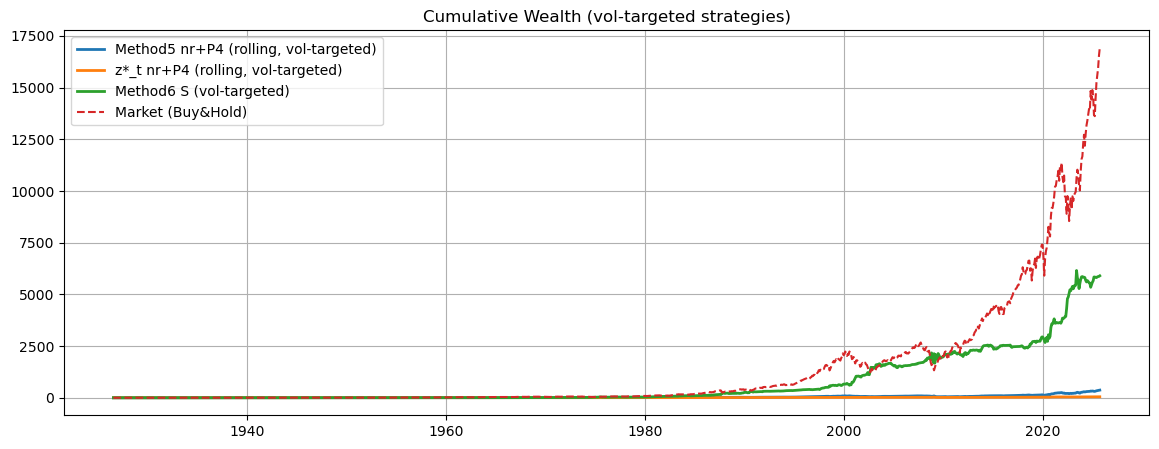

In [17]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import statsmodels.api as sm


# --------------------------------------------------
# Fama-French 読み込み
# --------------------------------------------------
def load_ff_monthly_from_ken_french(csv_path: str) -> pd.DataFrame:
    raw = pd.read_csv(csv_path, skiprows=4)
    num = pd.to_numeric(raw['Unnamed: 0'], errors='coerce')
    mask_monthly = num > 10000
    monthly = raw[mask_monthly].copy()
    monthly = monthly.rename(columns={'Unnamed: 0': 'date'})
    monthly['date'] = pd.to_datetime(monthly['date'].astype(int), format="%Y%m")
    monthly = monthly.set_index('date').sort_index()

    for col in ['Mkt-RF', 'RF']:
        monthly[col] = pd.to_numeric(monthly[col], errors='coerce')

    ff = monthly[['Mkt-RF', 'RF']].copy()
    ff['mkt_excess'] = ff['Mkt-RF'] / 100.0
    ff['rf']         = ff['RF'] / 100.0
    return ff[['mkt_excess', 'rf']].dropna()


def classify_month_type(index: pd.DatetimeIndex) -> pd.Series:
    mt = pd.Series(index=index, dtype="object")
    for t in index:
        m = t.month % 3
        if m == 1:
            mt[t] = 'N'
        elif m == 2:
            mt[t] = 'R'
        else:
            mt[t] = '3'
    return mt


def add_nr_and_p4(ff: pd.DataFrame) -> pd.DataFrame:
    df = ff.copy()
    df["month_type"] = classify_month_type(df.index)

    dates = df.index.to_list()
    mt = df["month_type"].values
    mkt = df["mkt_excess"].values

    nr_dates = []
    mkt_nr_list = []
    past_newsy_indices = []
    mkt_nm1 = []
    mkt_nm2 = []
    mkt_nm3 = []
    mkt_nm4 = []

    for i, t in enumerate(dates):
        # nr(t): 直近の N or R
        nr_idx = None
        j = i - 1
        while j >= 0:
            if mt[j] in ("N", "R"):
                nr_idx = j
                break
            j -= 1
        if nr_idx is None:
            nr_dates.append(None)
            mkt_nr_list.append(np.nan)
        else:
            nr_dates.append(dates[nr_idx])
            mkt_nr_list.append(mkt[nr_idx])

        # N (newsy) の履歴更新
        if mt[i] == "N":
            past_newsy_indices.append(i)

        # nm(t,j)
        cand = [k for k in past_newsy_indices if k < i]
        cand = sorted(cand, reverse=True)
        vals = []
        for jj in range(4):
            if jj < len(cand):
                vals.append(mkt[cand[jj]])
            else:
                vals.append(np.nan)

        mkt_nm1.append(vals[0])
        mkt_nm2.append(vals[1])
        mkt_nm3.append(vals[2])
        mkt_nm4.append(vals[3])

    df["nr_date"] = nr_dates
    df["mkt_nr"]  = mkt_nr_list
    df["mkt_nm1"] = mkt_nm1
    df["mkt_nm2"] = mkt_nm2
    df["mkt_nm3"] = mkt_nm3
    df["mkt_nm4"] = mkt_nm4
    df["P4"]      = df[["mkt_nm1", "mkt_nm2", "mkt_nm3", "mkt_nm4"]].mean(axis=1)
    df["mkt_nm4_avg"] = df["P4"]
    return df


def compute_S_and_x_for_method6(mkt_total: pd.Series):
    idx = mkt_total.index
    month_type = classify_month_type(idx)
    is_newsy = (month_type == "N")

    news_series = mkt_total[is_newsy]

    S = pd.Series(index=idx, dtype=float)
    for t in idx:
        past = news_series[news_series.index <= t]
        if len(past) >= 4:
            S[t] = past.iloc[-4:].sum()
        else:
            S[t] = np.nan

    x = pd.Series(index=idx, dtype=float)
    S_hist = []
    for i in range(1, len(idx)):
        prev_date = idx[i-1]
        curr_date = idx[i]
        s_prev = S.loc[prev_date]
        if np.isnan(s_prev):
            x[curr_date] = np.nan
            continue
        S_hist.append(s_prev)
        s_bar = float(np.mean(S_hist))
        sign = -1.0 if is_newsy[curr_date] else 1.0
        x[curr_date] = sign * (s_prev - s_bar)

    return S, x, month_type

def vol_target_from_weights(
    mkt_excess: pd.Series,
    rf: pd.Series,
    w_raw: pd.Series,
    target_vol: float = 0.05,
) -> pd.DataFrame:
    """
    任意の raw weight w_raw に対して、
    - strat_excess_raw = w_raw * mkt_excess
    - その実現ボラからスケール係数を計算
    - 目標ボラ target_vol に合わせる

    戻り値:
      DataFrame: ['mkt_excess','rf','w_raw','w_scaled',
                  'strat_excess_raw','strat_excess','strat_total']
    """
    # アライン
    data = pd.concat(
        [mkt_excess.rename("mkt_excess"),
         rf.rename("rf"),
         w_raw.rename("w_raw")],
        axis=1
    ).dropna(subset=["mkt_excess", "rf"])

    strat_excess_raw = data["w_raw"] * data["mkt_excess"]
    realized_vol = strat_excess_raw.std(ddof=1)

    if realized_vol is None or realized_vol == 0 or np.isnan(realized_vol):
        scale = 1.0
    else:
        scale = target_vol / realized_vol

    w_scaled = data["w_raw"] * scale
    strat_excess = strat_excess_raw * scale
    strat_total  = data["rf"] + strat_excess

    out = pd.DataFrame({
        "mkt_excess": data["mkt_excess"],
        "rf": data["rf"],
        "w_raw": data["w_raw"],
        "w_scaled": w_scaled,
        "strat_excess_raw": strat_excess_raw,
        "strat_excess": strat_excess,
        "strat_total": strat_total,
    })
    out.attrs["scale"] = scale
    out.attrs["target_vol"] = target_vol
    return out

def build_method5_nr_p4_raw_weights(
    ff: pd.DataFrame,
    lookback_years: int = 20,
    min_obs: int = 120,
) -> pd.Series:
    """
    Method 5（nr + P4 joint）の rolling OLS 版。
    - 直近 lookback_years 年で nr, P4 → mkt_excess を回帰
    - 次月の予測値 \hat r_{t+1} を raw weight として返す

    戻り値:
      w_raw: index=ff.index, values= raw weight
    """
    df = add_nr_and_p4(ff)
    idx = df.index

    beta_nr  = pd.Series(index=idx, dtype=float)
    beta_p4  = pd.Series(index=idx, dtype=float)
    alpha    = pd.Series(index=idx, dtype=float)

    for i, t in enumerate(idx):
        if i == 0:
            continue

        end_date = idx[i-1]
        start_date = end_date - pd.DateOffset(years=lookback_years)
        mask = (idx >= start_date) & (idx <= end_date)
        sub = df.loc[mask, ["mkt_excess", "mkt_nr", "P4"]].dropna()

        if len(sub) < min_obs:
            continue

        y = sub["mkt_excess"]
        X = sub[["mkt_nr", "P4"]]
        X_const = sm.add_constant(X)
        model = sm.OLS(y, X_const).fit()

        alpha[t]   = model.params.get("const", np.nan)
        beta_nr[t] = model.params.get("mkt_nr", np.nan)
        beta_p4[t] = model.params.get("P4", np.nan)

    # 1期先の予測値を raw weight に
    w_raw = pd.Series(index=idx, dtype=float)
    for i in range(len(idx)-1):
        t = idx[i]
        t_next = idx[i+1]

        if any(np.isnan([alpha[t], beta_nr[t], beta_p4[t], df.at[t, "mkt_nr"], df.at[t, "P4"]])):
            w_raw[t_next] = 0.0
            continue

        nr_t = df.at[t, "mkt_nr"]
        p4_t = df.at[t, "P4"]
        w_raw[t_next] = alpha[t] + beta_nr[t]*nr_t + beta_p4[t]*p4_t

    return w_raw

def build_z_star_online(
    ff: pd.DataFrame,
    lookback_years: int = 20,
    min_obs: int = 120,
) -> pd.DataFrame:
    """
    nr + P4 joint rolling OLS から z*_t を作る（既出の関数を整理した版）。
    """
    df = add_nr_and_p4(ff)
    idx = df.index

    beta_nr = pd.Series(index=idx, dtype=float)
    beta_p4 = pd.Series(index=idx, dtype=float)

    for i, t in enumerate(idx):
        if i == 0:
            continue

        end_date = idx[i-1]
        start_date = end_date - pd.DateOffset(years=lookback_years)
        mask = (idx >= start_date) & (idx <= end_date)
        sub = df.loc[mask, ["mkt_excess", "mkt_nr", "P4"]].dropna()

        if len(sub) < min_obs:
            continue

        y = sub["mkt_excess"]
        X = sub[["mkt_nr", "P4"]]
        X_const = sm.add_constant(X)
        model = sm.OLS(y, X_const).fit()

        beta_nr[t] = model.params.get("mkt_nr", np.nan)
        beta_p4[t] = model.params.get("P4", np.nan)

    df["beta_nr"]  = beta_nr
    df["beta_P4"]  = beta_p4
    df["z_star"]   = df["beta_nr"] * df["mkt_nr"] + df["beta_P4"] * df["P4"]
    return df


def build_zstar_raw_weights(ff: pd.DataFrame,
                            lookback_years: int = 20,
                            min_obs: int = 120) -> pd.Series:
    """
    z*_t をそのまま raw weight として使う。
    """
    df_z = build_z_star_online(ff, lookback_years=lookback_years, min_obs=min_obs)
    w_raw = df_z["z_star"].fillna(0.0)
    return w_raw

def build_z_star_online(
    ff: pd.DataFrame,
    lookback_years: int = 20,
    min_obs: int = 120,
) -> pd.DataFrame:
    """
    nr + P4 joint rolling OLS から z*_t を作る（既出の関数を整理した版）。
    """
    df = add_nr_and_p4(ff)
    idx = df.index

    beta_nr = pd.Series(index=idx, dtype=float)
    beta_p4 = pd.Series(index=idx, dtype=float)

    for i, t in enumerate(idx):
        if i == 0:
            continue

        end_date = idx[i-1]
        start_date = end_date - pd.DateOffset(years=lookback_years)
        mask = (idx >= start_date) & (idx <= end_date)
        sub = df.loc[mask, ["mkt_excess", "mkt_nr", "P4"]].dropna()

        if len(sub) < min_obs:
            continue

        y = sub["mkt_excess"]
        X = sub[["mkt_nr", "P4"]]
        X_const = sm.add_constant(X)
        model = sm.OLS(y, X_const).fit()

        beta_nr[t] = model.params.get("mkt_nr", np.nan)
        beta_p4[t] = model.params.get("P4", np.nan)

    df["beta_nr"]  = beta_nr
    df["beta_P4"]  = beta_p4
    df["z_star"]   = df["beta_nr"] * df["mkt_nr"] + df["beta_P4"] * df["P4"]
    return df


def build_zstar_raw_weights(ff: pd.DataFrame,
                            lookback_years: int = 20,
                            min_obs: int = 120) -> pd.Series:
    """
    z*_t をそのまま raw weight として使う。
    """
    df_z = build_z_star_online(ff, lookback_years=lookback_years, min_obs=min_obs)
    w_raw = df_z["z_star"].fillna(0.0)
    return w_raw

def build_method6_raw_weights(
    ff: pd.DataFrame,
    min_obs: int = 120,
) -> (pd.Series, pd.Series, pd.Series):
    """
    Method 6 の raw weight を構成する。
    戻り値:
      x      : predictor x_t
      beta   : rolling β_t
      w_raw  : β_t * x_t
    """
    mkt_excess = ff["mkt_excess"].copy()
    rf         = ff["rf"].copy()
    mkt_total  = mkt_excess + rf
    idx        = mkt_total.index

    S, x, month_type = compute_S_and_x_for_method6(mkt_total)
    mkt_mean = mkt_total.expanding().mean().shift(1)
    y_adj    = mkt_total - mkt_mean

    beta = pd.Series(index=idx, dtype=float)

    for i, t in enumerate(idx):
        mask = (idx <= t) & x.notna() & y_adj.notna()
        n = mask.sum()
        if n < min_obs:
            beta[t] = np.nan
            continue

        xi = x[mask].values
        yi = y_adj[mask].values
        denom = (xi ** 2).sum()
        beta[t] = (xi * yi).sum() / denom if denom > 0 else np.nan

    w_raw = pd.Series(index=idx, dtype=float)
    for i in range(len(idx)):
        t = idx[i]
        if np.isnan(beta[t]) or np.isnan(x[t]):
            w_raw[t] = 0.0
        else:
            w_raw[t] = beta[t] * x[t]

    return x, beta, w_raw

if __name__ == "__main__":
    csv_path = "F-F_Research_Data_Factors.csv"
    ff = load_ff_monthly_from_ken_french(csv_path)

    target_vol = 0.05  # 月次 5% など

    # 1) Method 5 (nr + P4, rolling OLS)
    w_m5 = build_method5_nr_p4_raw_weights(ff, lookback_years=20, min_obs=120)
    strat_m5 = vol_target_from_weights(ff["mkt_excess"], ff["rf"], w_m5, target_vol=target_vol)

    # 2) z*_t (nr + P4, rolling OLS → β_nr, β_P4 の線形結合)
    w_zstar = build_zstar_raw_weights(ff, lookback_years=20, min_obs=120)
    strat_zstar = vol_target_from_weights(ff["mkt_excess"], ff["rf"], w_zstar, target_vol=target_vol)

    # 3) Method 6 (β_t x_t)
    x_m6, beta_m6, w_m6 = build_method6_raw_weights(ff, min_obs=120)
    strat_m6 = vol_target_from_weights(ff["mkt_excess"], ff["rf"], w_m6, target_vol=target_vol)

    # 簡易比較（年率平均・ボラ・シャープ）
    def annualized_stats(r: pd.Series):
        r = r.dropna()
        mu_m = r.mean()
        sd_m = r.std(ddof=1)
        mu_a = mu_m * 12
        sd_a = sd_m * math.sqrt(12)
        sharpe = mu_a / sd_a if sd_a > 0 else np.nan
        return mu_a, sd_a, sharpe

    for label, df_strat in [
        ("Method5_nrP4_rolling", strat_m5),
        ("zstar_nrP4_rolling",   strat_zstar),
        ("Method6_S",            strat_m6),
    ]:
        mu, sd, sh = annualized_stats(df_strat["strat_total"])
        print(f"[{label}] mu={mu:.2%}, sigma={sd:.2%}, Sharpe={sh:.2f}")

    # 累積リターンの比較
    common_index = strat_m5["strat_total"].dropna().index
    common_index = common_index.intersection(strat_zstar["strat_total"].dropna().index)
    common_index = common_index.intersection(strat_m6["strat_total"].dropna().index)

    sw_m5    = (1.0 + strat_m5["strat_total"].reindex(common_index)).cumprod()
    sw_zstar = (1.0 + strat_zstar["strat_total"].reindex(common_index)).cumprod()
    sw_m6    = (1.0 + strat_m6["strat_total"].reindex(common_index)).cumprod()
    mw       = (1.0 + (ff["mkt_excess"] + ff["rf"]).reindex(common_index)).cumprod()

    plt.figure(figsize=(14,5))
    plt.plot(sw_m5,    label="Method5 nr+P4 (rolling, vol-targeted)", linewidth=2)
    plt.plot(sw_zstar, label="z*_t nr+P4 (rolling, vol-targeted)",    linewidth=2)
    plt.plot(sw_m6,    label="Method6 S (vol-targeted)",              linewidth=2)
    plt.plot(mw,       label="Market (Buy&Hold)", linestyle="--")
    plt.legend()
    plt.grid(True)
    plt.title("Cumulative Wealth (vol-targeted strategies)")
    plt.show()


(1099, 2)
[Method 6 (β_t x_t, vol-targeted @ 5%)]
  Annualized Return : 9.44%
  Annualized Vol    : 17.35%
  Sharpe Ratio      : 0.54
  Scale (k)         : 94.304
[mkt]
  Annualized Return : 8.02%
  Annualized Vol    : 18.49%
  Sharpe Ratio      : 0.43


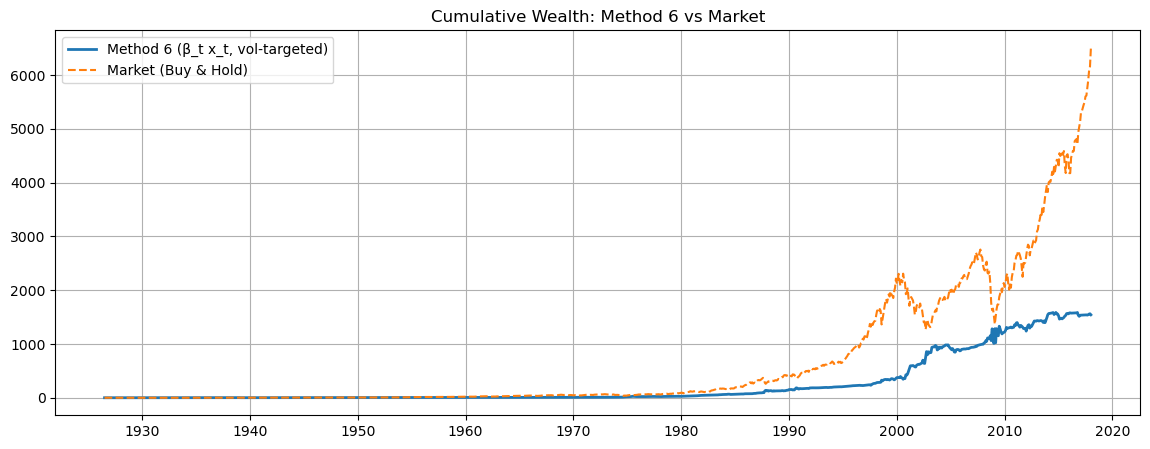

In [50]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import statsmodels.api as sm


# ============================================================
# 0. Fama-French (monthly) 読み込み
# ============================================================

def load_ff_monthly_from_ken_french(csv_path: str) -> pd.DataFrame:
    """
    Ken French の F-F_Research_Data_Factors.csv から
    月次の Mkt-RF, RF を抽出して DataFrame を返す。

    戻り値: index = 月末 (Timestamp)
            columns = ['mkt_excess', 'rf']
    """
    raw = pd.read_csv(csv_path, skiprows=4)

    # "YYYYMM" のような整数が入っている行だけ月次
    num = pd.to_numeric(raw['Unnamed: 0'], errors='coerce')
    mask_monthly = num > 10000
    monthly = raw[mask_monthly].copy()

    monthly = monthly.rename(columns={'Unnamed: 0': 'date'})
    monthly['date'] = pd.to_datetime(monthly['date'].astype(int), format="%Y%m")
    monthly = monthly.set_index('date').sort_index()

    for col in ['Mkt-RF', 'RF']:
        monthly[col] = pd.to_numeric(monthly[col], errors='coerce')

    ff = monthly[['Mkt-RF', 'RF']].copy()
    ff['mkt_excess'] = ff['Mkt-RF'] / 100.0
    ff['rf']         = ff['RF'] / 100.0

    return ff[['mkt_excess', 'rf']].dropna()


# ============================================================
# 1. month_type: N / R / 3 の分類
# ============================================================

def classify_month_type(index: pd.DatetimeIndex) -> pd.Series:
    """
    Guo & Wachter / Guo (2025) の 3 ヶ月サイクルに対応する月タイプ。
    - month % 3 == 1 -> 'N' (Newsy)
    - month % 3 == 2 -> 'R' (Repetitive)
    - month % 3 == 0 -> '3' (third month)
    """
    mt = pd.Series(index=index, dtype="object")
    for t in index:
        m = t.month % 3
        if m == 1:
            mt[t] = 'N'
        elif m == 2:
            mt[t] = 'R'
        else:
            mt[t] = '3'
    return mt


# ============================================================
# 2. S_t, x_t の計算（Method 6 用）
# ============================================================

def compute_S_and_x_for_method6(mkt_total: pd.Series):
    """
    Guo (2025) の Method 6 に対応する S_t, x_t を構成する。

    引数:
        mkt_total : 市場トータルリターンシリーズ (Mkt-RF + RF)

    戻り値:
        S          : 直近4つの Newsy 月トータルリターンの和
        x          : sign-adjusted & demeaned S (構造モデルの mispricing 指標)
        month_type : 'N'/'R'/'3' の月タイプ
    """
    idx = mkt_total.index
    month_type = classify_month_type(idx)
    is_newsy = (month_type == "N")

    # Newsy 月のみ抽出
    news_series = mkt_total[is_newsy]

    # 直近4つの Newsy 月の合計 S_t
    S = pd.Series(index=idx, dtype=float)
    for t in idx:
        past = news_series[news_series.index <= t]
        if len(past) >= 4:
            S[t] = past.iloc[-4:].sum()
        else:
            S[t] = np.nan

    # x_t = sign * (S_{t-1} - mean_{s<=t-1} S_s)
    x = pd.Series(index=idx, dtype=float)
    S_hist = []
    for i in range(1, len(idx)):
        prev_date = idx[i-1]
        curr_date = idx[i]

        s_prev = S.loc[prev_date]
        if np.isnan(s_prev):
            x[curr_date] = np.nan
            continue

        S_hist.append(s_prev)
        s_bar = float(np.mean(S_hist))

        sign = -1.0 if is_newsy[curr_date] else 1.0
        x[curr_date] = sign * (s_prev - s_bar)

    return S, x, month_type


# ============================================================
# 3. Method 6: β_t x_t のオンライン推定
# ============================================================

def build_method6_raw_weights(
    ff: pd.DataFrame,
    min_obs: int = 120,
) -> (pd.Series, pd.Series, pd.Series):
    """
    Method 6 の「構造モデル」実装：
      R_t^tot = mean_{s<t} R_s^tot + β x_t + ε_t
    から β をオンライン推定し、
      w_t^raw = β_t x_t
    を生成する。

    引数:
        ff      : ['mkt_excess','rf'] を持つ DataFrame
        min_obs : β 推定に必要な最小サンプル数

    戻り値:
        x       : mispricing predictor x_t
        beta    : 各時点 t における β_t
        w_raw   : β_t x_t （NaN は 0 に置き換え）
    """
    mkt_excess = ff["mkt_excess"].copy()
    rf         = ff["rf"].copy()
    mkt_total  = mkt_excess + rf
    idx        = mkt_total.index

    # S_t, x_t を計算
    S, x, month_type = compute_S_and_x_for_method6(mkt_total)

    # 無条件平均リターン（ランニング平均）を構成
    mkt_mean = mkt_total.expanding().mean().shift(1)

    # y_t = R_t^tot - mean_{s<t} R_s^tot
    y_adj    = mkt_total - mkt_mean

    beta = pd.Series(index=idx, dtype=float)

    for i, t in enumerate(idx):
        # t 時点で利用可能な過去情報のみを使って β_t を推定
        mask = (idx <= t) & x.notna() & y_adj.notna()
        n = mask.sum()
        if n < min_obs:
            beta[t] = np.nan
            continue

        xi = x[mask].values
        yi = y_adj[mask].values
        denom = (xi ** 2).sum()
        beta[t] = (xi * yi).sum() / denom if denom > 0 else np.nan

    # w_t^raw = β_t x_t
    w_raw = pd.Series(index=idx, dtype=float)
    for t in idx:
        if np.isnan(beta[t]) or np.isnan(x[t]):
            w_raw[t] = 0.0
        else:
            w_raw[t] = beta[t] * x[t]

    return x, beta, w_raw

def build_method6_raw_weights_rolling(
    ff: pd.DataFrame,
    lookback_years: int = 20,
    min_obs: int = 120,
) -> (pd.Series, pd.Series, pd.Series):
    """
    Method 6 の「構造モデル」実装の rolling 版：
      R_t^tot = mean_{s<t} R_s^tot + β x_t + ε_t
    から β_t を「直近 lookback_years 年」のデータだけで推定し、
      w_t^raw = β_t x_t
    を生成する。

    引数:
        ff            : ['mkt_excess','rf'] を持つ DataFrame
        lookback_years: β 推定に用いる rolling window の年数（例：20）
        min_obs       : 窓内で β 推定に必要な最小サンプル数（月数）

    戻り値:
        x       : mispricing predictor x_t
        beta    : 各時点 t における rolling β_t
        w_raw   : β_t x_t （NaN は 0 に置き換え）
    """
    mkt_excess = ff["mkt_excess"].copy()
    rf         = ff["rf"].copy()
    mkt_total  = mkt_excess + rf
    idx        = mkt_total.index

    # S_t, x_t を計算（expanding 版と同じ定義）
    S, x, month_type = compute_S_and_x_for_method6(mkt_total)

    # 無条件平均リターン（ランニング平均）は Method 6 と同じ構造
    mkt_mean = mkt_total.expanding().mean().shift(1)
    # y_t = R_t^tot - mean_{s<t} R_s^tot
    y_adj    = mkt_total - mkt_mean

    beta = pd.Series(index=idx, dtype=float)

    lookback_months = lookback_years * 12

    for i, t in enumerate(idx):
        # t を含む直近 lookback_months 本のインデックス
        start_i = max(0, i - lookback_months + 1)
        win_idx = idx[start_i:(i + 1)]

        # この window の中で x, y_adj が欠損でないものだけ使用
        x_win = x.loc[win_idx]
        y_win = y_adj.loc[win_idx]
        mask  = x_win.notna() & y_win.notna()
        n     = mask.sum()

        if n < min_obs:
            beta[t] = np.nan
            continue

        xi = x_win[mask].values
        yi = y_win[mask].values
        denom = (xi ** 2).sum()
        beta[t] = (xi * yi).sum() / denom if denom > 0 else np.nan

    # w_t^raw = β_t x_t
    w_raw = pd.Series(index=idx, dtype=float)
    for t in idx:
        if np.isnan(beta[t]) or np.isnan(x[t]):
            w_raw[t] = 0.0
        else:
            w_raw[t] = beta[t] * x[t]

    return x, beta, w_raw


# ============================================================
# 4. ボラティリティ・ターゲッティング
# ============================================================

def vol_target_from_weights(
    mkt_excess: pd.Series,
    rf: pd.Series,
    w_raw: pd.Series,
    target_vol: float = 0.05,
) -> pd.DataFrame:
    """
    任意の raw weight w_raw に対して、
    - strat_excess_raw = w_raw * mkt_excess
    - その実現ボラからスケール係数を計算
    - 目標ボラ target_vol に合わせる

    戻り値:
      DataFrame:
        ['mkt_excess','rf',
         'w_raw','w_scaled',
         'strat_excess_raw','strat_excess','strat_total']
    """
    data = pd.concat(
        [mkt_excess.rename("mkt_excess"),
         rf.rename("rf"),
         w_raw.rename("w_raw")],
        axis=1
    ).dropna(subset=["mkt_excess", "rf"])

    strat_excess_raw = data["w_raw"] * data["mkt_excess"]

    # 実現ボラ
    realized_vol = strat_excess_raw.std(ddof=1)
    if realized_vol is None or realized_vol == 0 or np.isnan(realized_vol):
        scale = 1.0
    else:
        scale = target_vol / realized_vol

    w_scaled     = data["w_raw"] * scale
    strat_excess = strat_excess_raw * scale
    strat_total  = data["rf"] + strat_excess

    out = pd.DataFrame({
        "mkt_excess": data["mkt_excess"],
        "rf": data["rf"],
        "w_raw": data["w_raw"],
        "w_scaled": w_scaled,
        "strat_excess_raw": strat_excess_raw,
        "strat_excess": strat_excess,
        "strat_total": strat_total,
    })
    out.attrs["scale"] = scale
    out.attrs["target_vol"] = target_vol
    return out


# ============================================================
# 5. 評価用のユーティリティ
# ============================================================

def annualized_stats(r: pd.Series):
    """
    月次リターン系列 r から年率平均・年率ボラ・年率シャープを計算。
    """
    r = r.dropna()
    mu_m = r.mean()
    sd_m = r.std(ddof=1)
    mu_a = mu_m * 12
    sd_a = sd_m * math.sqrt(12)
    sharpe = mu_a / sd_a if sd_a > 0 else np.nan
    return mu_a, sd_a, sharpe


# ============================================================
# 6. 実行例 (main)
# ============================================================

if __name__ == "__main__":
    # 1) Fama-French 月次データを読み込み
    csv_path = "F-F_Research_Data_Factors.csv"
    ff = load_ff_monthly_from_ken_french(csv_path)
    ff = ff.loc[:"2018-01-01"]
    print(ff.shape)
    # 2) Method 6: β_t x_t の raw weights を構成
    #x_m6, beta_m6, w_m6 = build_method6_raw_weights(ff, min_obs=120)
    x_m6, beta_m6, w_m6 = build_method6_raw_weights_rolling(ff,lookback_years=20,min_obs=120,)

    # 3) ボラターゲッティング（例: 月次 5%）
    target_vol = 0.05
    strat_m6 = vol_target_from_weights(ff["mkt_excess"], ff["rf"], w_m6, target_vol=target_vol)

    # 4) パフォーマンス指標
    mu_a, sd_a, sh = annualized_stats(strat_m6["strat_total"])
    print(f"[Method 6 (β_t x_t, vol-targeted @ {target_vol:.0%})]")
    print(f"  Annualized Return : {mu_a:.2%}")
    print(f"  Annualized Vol    : {sd_a:.2%}")
    print(f"  Sharpe Ratio      : {sh:.2f}")
    print(f"  Scale (k)         : {strat_m6.attrs['scale']:.3f}")

    mu_b, sd_b, sh_b = annualized_stats(ff["mkt_excess"])
    print(f"[mkt]")
    print(f"  Annualized Return : {mu_b:.2%}")
    print(f"  Annualized Vol    : {sd_b:.2%}")
    print(f"  Sharpe Ratio      : {sh_b:.2f}")
    
    # 5) 累積リターンのプロット（市場 vs Method 6）
    common_index = strat_m6["strat_total"].dropna().index
    mkt_total = (ff["mkt_excess"] + ff["rf"]).reindex(common_index)
    sw_m6 = (1.0 + strat_m6["strat_total"].reindex(common_index)).cumprod()
    mw    = (1.0 + mkt_total).cumprod()

    plt.figure(figsize=(14, 5))
    plt.plot(sw_m6, label="Method 6 (β_t x_t, vol-targeted)", linewidth=2)
    plt.plot(mw,    label="Market (Buy & Hold)", linestyle="--")
    plt.title("Cumulative Wealth: Method 6 vs Market")
    plt.legend()
    plt.grid(True)
    plt.show()


=== Basic Descriptive Statistics for S_t and x_t ===
                 S            x
count  1181.000000  1181.000000
mean      0.049463     0.000367
std       0.094142     0.093886
min      -0.210200    -0.582524
25%      -0.012000    -0.058436
50%       0.055300     0.002130
75%       0.104100     0.057119
max       0.606600     0.598484

Correlations:
  Corr(S_t, x_t)         = 0.4627
  Corr(x_t, r_(t+1))     = 0.0009


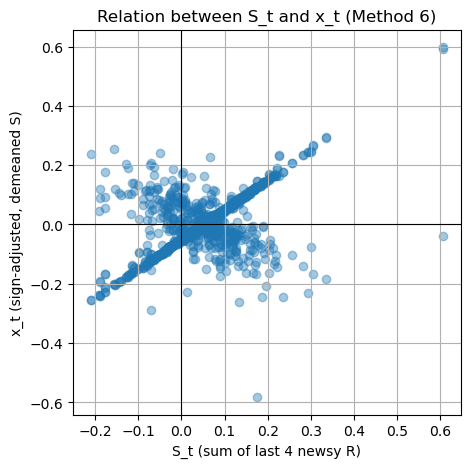


=== Predictability Regression: r_(t+1) on x_t ===
                            OLS Regression Results                            
Dep. Variable:            lead_excess   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                 0.0004931
Date:                Wed, 10 Dec 2025   Prob (F-statistic):              0.982
Time:                        20:23:27   Log-Likelihood:                 1787.0
No. Observations:                1181   AIC:                            -3570.
Df Residuals:                    1179   BIC:                            -3560.
Df Model:                           1                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c

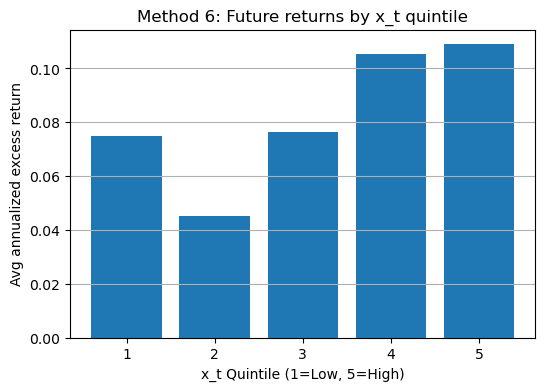


=== Rolling 10-year correlation: x_t vs r_(t+1) ===


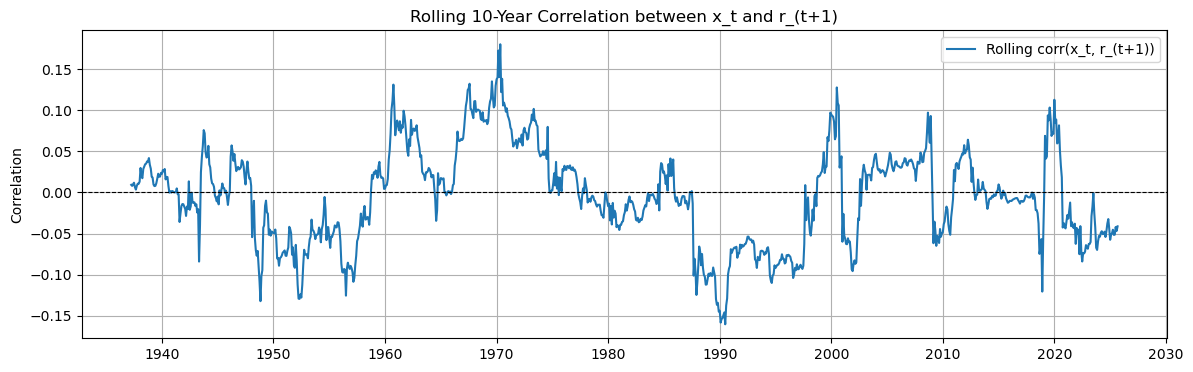


=== Predictability r_(t+1) ~ x_t by month_type ===
[N] beta_x = -0.0161, t = -0.45, R^2 = 0.0008
[R] beta_x = 0.1114, t = 3.38, R^2 = 0.0440
[3] beta_x = -0.0951, t = -2.71, R^2 = 0.0243


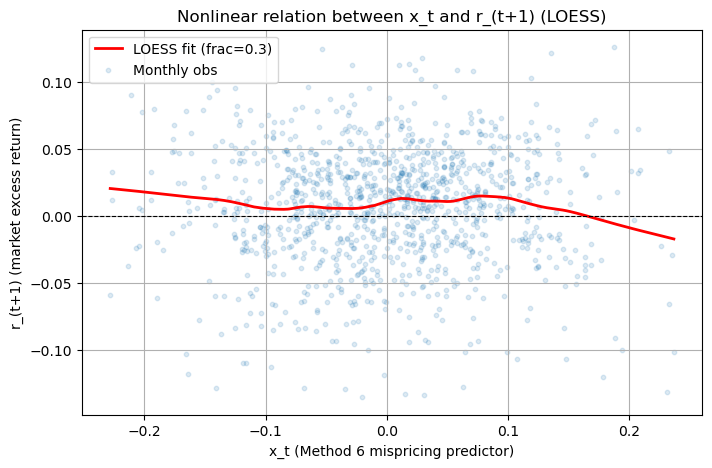

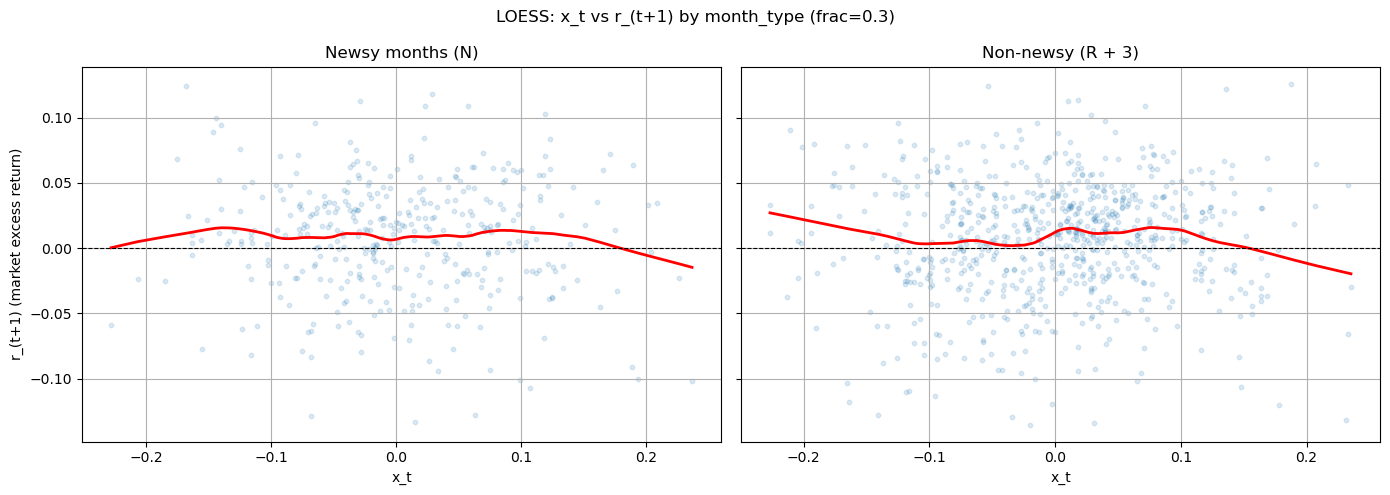

In [36]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.nonparametric.smoothers_lowess import lowess

# ============================================================
# 0. Fama-French (monthly) 読み込み
# ============================================================

def load_ff_monthly_from_ken_french(csv_path: str) -> pd.DataFrame:
    """
    Ken French の F-F_Research_Data_Factors.csv から
    月次の Mkt-RF, RF を抽出して DataFrame を返す。

    戻り値: index = 月末 (Timestamp)
            columns = ['mkt_excess', 'rf']
    """
    raw = pd.read_csv(csv_path, skiprows=4)

    # "YYYYMM" のような整数が入っている行だけ月次
    num = pd.to_numeric(raw['Unnamed: 0'], errors='coerce')
    mask_monthly = num > 10000
    monthly = raw[mask_monthly].copy()

    monthly = monthly.rename(columns={'Unnamed: 0': 'date'})
    monthly['date'] = pd.to_datetime(monthly['date'].astype(int), format="%Y%m")
    monthly = monthly.set_index('date').sort_index()

    for col in ['Mkt-RF', 'RF']:
        monthly[col] = pd.to_numeric(monthly[col], errors='coerce')

    ff = monthly[['Mkt-RF', 'RF']].copy()
    ff['mkt_excess'] = ff['Mkt-RF'] / 100.0
    ff['rf']         = ff['RF'] / 100.0

    return ff[['mkt_excess', 'rf']].dropna()


# ============================================================
# 1. month_type: N / R / 3 の分類
# ============================================================

def classify_month_type(index: pd.DatetimeIndex) -> pd.Series:
    """
    Guo & Wachter / Guo (2025) の 3 ヶ月サイクルに対応する月タイプ。
    - month % 3 == 1 -> 'N' (Newsy)
    - month % 3 == 2 -> 'R' (Repetitive)
    - month % 3 == 0 -> '3' (third month)
    """
    mt = pd.Series(index=index, dtype="object")
    for t in index:
        m = t.month % 3
        if m == 1:
            mt[t] = 'N'
        elif m == 2:
            mt[t] = 'R'
        else:
            mt[t] = '3'
    return mt


# ============================================================
# 2. S_t, x_t の計算（Method 6 用）
# ============================================================

def compute_S_and_x_for_method6(mkt_total: pd.Series):
    """
    Guo (2025) の Method 6 に対応する S_t, x_t を構成する。

    引数:
        mkt_total : 市場トータルリターンシリーズ (Mkt-RF + RF)

    戻り値:
        S          : 直近4つの Newsy 月トータルリターンの和
        x          : sign-adjusted & demeaned S (構造モデルの mispricing 指標)
        month_type : 'N'/'R'/'3' の月タイプ
    """
    idx = mkt_total.index
    month_type = classify_month_type(idx)
    is_newsy = (month_type == "N")

    # Newsy 月のみ抽出
    news_series = mkt_total[is_newsy]

    # 直近4つの Newsy 月の合計 S_t
    S = pd.Series(index=idx, dtype=float)
    for t in idx:
        past = news_series[news_series.index <= t]
        if len(past) >= 4:
            S[t] = past.iloc[-4:].sum()
        else:
            S[t] = np.nan

    # x_t = sign * (S_{t-1} - mean_{s<=t-1} S_s)
    x = pd.Series(index=idx, dtype=float)
    S_hist = []
    for i in range(1, len(idx)):
        prev_date = idx[i-1]
        curr_date = idx[i]

        s_prev = S.loc[prev_date]
        if np.isnan(s_prev):
            x[curr_date] = np.nan
            continue

        S_hist.append(s_prev)
        s_bar = float(np.mean(S_hist))

        sign = -1.0 if is_newsy[curr_date] else 1.0
        x[curr_date] = sign * (s_prev - s_bar)

    return S, x, month_type


# ============================================================
# 3. Method 6 用データセット構築：
#    リターン + S_t + x_t + リードリターン
# ============================================================

def build_method6_dataset(ff: pd.DataFrame) -> pd.DataFrame:
    """
    Method 6 の仮定検証用データセットを構築する。

    columns:
        mkt_excess : 市場超過リターン r_t
        rf         : 無リスクリターン
        mkt_total  : トータルリターン R_t
        month_type : 'N'/'R'/'3'
        S          : 直近4 Newsy 月トータルリターンの和 (S_t)
        x          : mispricing 指標 (x_t)
        lead_excess: r_{t+1}
        lead_total : R_{t+1}
        S_lag      : S_{t-1} (Newsy/Non-newsy ごとの符号検証用)
    """
    df = ff.copy()
    df["mkt_total"] = df["mkt_excess"] + df["rf"]

    # month_type, S, x を作成
    S, x, month_type = compute_S_and_x_for_method6(df["mkt_total"])
    df["month_type"] = month_type
    df["S"] = S
    df["x"] = x

    # lead リターン（1期先）
    df["lead_excess"] = df["mkt_excess"].shift(-1)
    df["lead_total"]  = df["mkt_total"].shift(-1)

    # S_{t-1} を明示的に作る（S_lag）
    df["S_lag"] = df["S"].shift(1)

    # 分析に不要な初期 NaN をある程度落とす
    df = df.dropna(subset=["mkt_excess", "mkt_total", "S", "x", "lead_excess", "lead_total"])

    return df


# ============================================================
# 4. Method 6 仮定を検証する分析関数群
# ============================================================

# 4-1. 基本統計: S, x の分布や相関を確認

def basic_stats_method6(df: pd.DataFrame):
    """
    S_t, x_t の基本統計や相関を出力する。
    Method 6 の「x がセンタリングされた mispricing 指標」として妥当かを確認する。
    """
    print("=== Basic Descriptive Statistics for S_t and x_t ===")
    print(df[["S", "x"]].describe())

    # 相関
    corr_S_x   = df["S"].corr(df["x"])
    corr_x_ret = df["x"].corr(df["lead_excess"])
    print("\nCorrelations:")
    print(f"  Corr(S_t, x_t)         = {corr_S_x:.4f}")
    print(f"  Corr(x_t, r_(t+1))     = {corr_x_ret:.4f}")

    # S_t と x_t の散布図
    plt.figure(figsize=(5, 5))
    plt.scatter(df["S"], df["x"], alpha=0.4)
    plt.axhline(0.0, color="black", linewidth=0.8)
    plt.axvline(0.0, color="black", linewidth=0.8)
    plt.xlabel("S_t (sum of last 4 newsy R)")
    plt.ylabel("x_t (sign-adjusted, demeaned S)")
    plt.title("Relation between S_t and x_t (Method 6)")
    plt.grid(True)
    plt.show()


# 4-2. predictability regression: r_{t+1} ~ x_t

def regression_predictability_x(df: pd.DataFrame):
    """
    Method 6 のコア仮定:
      E[r_{t+1} | info_t] ≈ β x_t
    を検証するため、時系列回帰を実施する。
    """
    print("\n=== Predictability Regression: r_(t+1) on x_t ===")

    # 切片あり、HAC標準誤差付き OLS (Newey-West) などを使ってもよいが、
    # ここではシンプルに OLS + robust(HC0)。
    y = df["lead_excess"]
    X = sm.add_constant(df["x"])
    model = sm.OLS(y, X).fit(cov_type="HC0")
    print(model.summary())

    beta = model.params["x"]
    tval = model.tvalues["x"]
    r2   = model.rsquared
    print(f"\n  beta_x  = {beta:.4f}, t = {tval:.2f}, R^2 = {r2:.4f}")


# 4-3. S_{t-1} の「符号反転仮定」検証：
#      Newsy vs Non-newsy で係数符号が異なるか

def regression_S_lag_by_monthtype(df: pd.DataFrame):
    """
    Guo のロジック：
      Newsy 月と Non-newsy 月では、S_{t-1} と r_t の関係の符号が逆になるはず
      → S をそのまま使うと予測方向が月タイプで変わる
      → これを単一指標にまとめるのが x_t

    ここでは、リターン r_t をS_{t-1}で回帰し、
    N月・NonN月（R+3）別の β を比較する。
    """
    print("\n=== Regression of r_t on S_(t-1) by month_type ===")

    # 1期先ではなく、当期リターンとの関係を見る（解釈は比較のため）
    df2 = df.dropna(subset=["S_lag", "mkt_excess"])

    # Newsy 月
    sub_N = df2[df2["month_type"] == "N"]
    # Non-newsy (R + 3)
    sub_nonN = df2[df2["month_type"] != "N"]

    def _reg(name, sub):
        if len(sub) < 30:
            print(f"[{name}] too few obs")
            return
        y = sub["mkt_excess"]
        X = sm.add_constant(sub["S_lag"])
        m = sm.OLS(y, X).fit(cov_type="HC0")
        beta = m.params["S_lag"]
        tval = m.tvalues["S_lag"]
        print(f"[{name}] beta_Slag = {beta:.4f}, t = {tval:.2f}, R^2 = {m.rsquared:.4f}")

    _reg("N", sub_N)
    _reg("Non-N (R+3)", sub_nonN)


# 4-4. ソート分析：x_t quintile による r_{t+1} の平均

def sort_x_quintiles(df: pd.DataFrame):
    """
    x_t の quintile ソートにより、x が高いほど r_{t+1} が単調に変化するかを確認する。
    """
    print("\n=== x_t Quintile Sort for r_(t+1) ===")

    df2 = df.dropna(subset=["x", "lead_excess"]).copy()
    df2["x_q"] = pd.qcut(df2["x"], 5, labels=False) + 1  # 1〜5

    res = df2.groupby("x_q")["lead_excess"].mean() * 12  # 年率換算
    print("Average annualized excess return by x_t quintile:")
    for q, val in res.items():
        print(f"  Quintile {q}: {val:.2%}")

    # プロット
    plt.figure(figsize=(6, 4))
    plt.bar(res.index.astype(str), res.values)
    plt.xlabel("x_t Quintile (1=Low, 5=High)")
    plt.ylabel("Avg annualized excess return")
    plt.title("Method 6: Future returns by x_t quintile")
    plt.grid(True, axis="y")
    plt.show()


# 4-5. Rolling correlation: x_t vs r_{t+1}

def rolling_corr_x_ret(df: pd.DataFrame, window_years: int = 10):
    """
    x_t と r_{t+1} の相関が時間的に安定しているかを確認するため、
    rolling (window_years 年) で相関係数を計算してプロットする。
    """
    print(f"\n=== Rolling {window_years}-year correlation: x_t vs r_(t+1) ===")

    df2 = df.dropna(subset=["x", "lead_excess"]).copy()
    window = window_years * 12

    rolling_corr = df2["x"].rolling(window).corr(df2["lead_excess"])

    plt.figure(figsize=(14, 4))
    #plt.plot(rolling_corr.index, rolling_corr, label="Rolling corr(x_t, r_(t+1))")
    plt.plot(rolling_corr, label="Rolling corr(x_t, r_(t+1))")
    plt.axhline(0.0, color="black", linewidth=0.8, linestyle="--")
    plt.title(f"Rolling {window_years}-Year Correlation between x_t and r_(t+1)")
    plt.ylabel("Correlation")
    plt.grid(True)
    plt.legend()
    plt.show()


# 4-6. Newsy / 非 Newsy ごとの x_t predictability

def predictability_by_monthtype(df: pd.DataFrame):
    """
    x_t の予測力が Newsy 月と Non-newsy 月でどう違うかを確認する。
    r_{t+1} ~ x_t を month_type ごとに回帰。
    """
    print("\n=== Predictability r_(t+1) ~ x_t by month_type ===")

    for mt in ["N", "R", "3"]:
        sub = df[df["month_type"] == mt].dropna(subset=["x", "lead_excess"])
        if len(sub) < 40:
            print(f"[{mt}] too few obs (N={len(sub)})")
            continue
        y = sub["lead_excess"]
        X = sm.add_constant(sub["x"])
        m = sm.OLS(y, X).fit(cov_type="HC0")
        beta = m.params["x"]
        tval = m.tvalues["x"]
        print(f"[{mt}] beta_x = {beta:.4f}, t = {tval:.2f}, R^2 = {m.rsquared:.4f}")

def plot_loess_x_vs_future_ret(df: pd.DataFrame, frac: float = 0.3, trim_quantile: float = 0.01):
    """
    x_t と r_{t+1} の関係について、LOESS（局所多項式）で
    非線形性を可視化する。

    引数:
        df            : build_method6_dataset で作成した DataFrame
                        （'x', 'lead_excess' を含む）
        frac          : lowess の平滑化パラメータ。0.3 ならサンプルの 30% を
                        近傍として局所回帰に使用（大きいほど平滑）。
        trim_quantile : 外れ値トリミング用。例えば 0.01 なら
                        上下 1% を切り落としてから LOESS を当てる。
    """
    df2 = df.dropna(subset=["x", "lead_excess"]).copy()

    # 外れ値トリミング（x, r_{t+1} 両方）
    if trim_quantile is not None and trim_quantile > 0:
        q_low_x  = df2["x"].quantile(trim_quantile)
        q_high_x = df2["x"].quantile(1 - trim_quantile)
        q_low_r  = df2["lead_excess"].quantile(trim_quantile)
        q_high_r = df2["lead_excess"].quantile(1 - trim_quantile)

        df2 = df2[
            (df2["x"] >= q_low_x) & (df2["x"] <= q_high_x) &
            (df2["lead_excess"] >= q_low_r) & (df2["lead_excess"] <= q_high_r)
        ].copy()

    x = df2["x"].values
    y = df2["lead_excess"].values  # 月次超過リターン

    # LOESS（局所多項式回帰）
    # return_sorted=True なので、x_smoothed は昇順にソートされた x。
    loess_res = lowess(endog=y, exog=x, frac=frac, return_sorted=True)
    x_smooth = loess_res[:, 0]
    y_smooth = loess_res[:, 1]

    # プロット
    plt.figure(figsize=(8, 5))
    plt.scatter(x, y, alpha=0.15, label="Monthly obs", s=10)
    plt.plot(x_smooth, y_smooth, color="red", linewidth=2.0, label=f"LOESS fit (frac={frac})")
    plt.axhline(0.0, color="black", linewidth=0.8, linestyle="--")
    plt.xlabel("x_t (Method 6 mispricing predictor)")
    plt.ylabel("r_(t+1) (market excess return)")
    plt.title("Nonlinear relation between x_t and r_(t+1) (LOESS)")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_loess_x_vs_future_ret_by_monthtype(df: pd.DataFrame, frac: float = 0.3, trim_quantile: float = 0.01):
    """
    x_t と r_{t+1} の LOESS 関係を、
    - Newsy (N)
    - Non-newsy (R + 3)
    に分けて比較する。
    """
    df2 = df.dropna(subset=["x", "lead_excess", "month_type"]).copy()

    # 共通のトリミング範囲を決める
    if trim_quantile is not None and trim_quantile > 0:
        q_low_x  = df2["x"].quantile(trim_quantile)
        q_high_x = df2["x"].quantile(1 - trim_quantile)
        q_low_r  = df2["lead_excess"].quantile(trim_quantile)
        q_high_r = df2["lead_excess"].quantile(1 - trim_quantile)
        df2 = df2[
            (df2["x"] >= q_low_x) & (df2["x"] <= q_high_x) &
            (df2["lead_excess"] >= q_low_r) & (df2["lead_excess"] <= q_high_r)
        ].copy()

    fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
    for ax, (label, mask) in zip(
        axes,
        [
            ("Newsy months (N)", df2["month_type"] == "N"),
            ("Non-newsy (R + 3)", df2["month_type"] != "N"),
        ]
    ):
        sub = df2[mask]
        if len(sub) < 50:
            ax.set_title(f"{label}: too few obs (N={len(sub)})")
            ax.axis("off")
            continue

        x = sub["x"].values
        y = sub["lead_excess"].values

        loess_res = lowess(endog=y, exog=x, frac=frac, return_sorted=True)
        x_smooth = loess_res[:, 0]
        y_smooth = loess_res[:, 1]

        ax.scatter(x, y, alpha=0.15, s=10)
        ax.plot(x_smooth, y_smooth, color="red", linewidth=2.0)
        ax.axhline(0.0, color="black", linewidth=0.8, linestyle="--")
        ax.set_xlabel("x_t")
        ax.set_title(label)
        ax.grid(True)

    axes[0].set_ylabel("r_(t+1) (market excess return)")
    fig.suptitle(f"LOESS: x_t vs r_(t+1) by month_type (frac={frac})")
    plt.tight_layout()
    plt.show()


# ============================================================
# 5. main: Method 6 仮定を裏付ける実証分析の一括実行
# ============================================================

if __name__ == "__main__":
    # 1) Fama-French データ読み込み
    csv_path = "F-F_Research_Data_Factors.csv"
    ff = load_ff_monthly_from_ken_french(csv_path)
    #ff = ff.loc["2020-01-01":]

    # 2) Method 6 用データセット構築
    df_m6 = build_method6_dataset(ff)

    # 3) 基本統計：S_t, x_t の分布と相関
    basic_stats_method6(df_m6)

    # 4) x_t の予測回帰：r_{t+1} ~ x_t
    regression_predictability_x(df_m6)

    # 5) S_{t-1} の符号反転仮定：
    #    Newsy vs Non-newsy で β_Slag の符号・大きさが違うか
    regression_S_lag_by_monthtype(df_m6)

    # 6) x_t Quintile による r_{t+1} の単調性チェック
    sort_x_quintiles(df_m6)

    # 7) Rolling correlation: x_t と r_{t+1} の関係が時系列的に安定か
    rolling_corr_x_ret(df_m6, window_years=10)

    # 8) Newsy / Repetitive / 3rd 別の x_t predictability
    predictability_by_monthtype(df_m6)

    # 追加：LOESS による非線形性の可視化
    plot_loess_x_vs_future_ret(df_m6, frac=0.3, trim_quantile=0.01)

    # （任意）Newsy / 非 Newsy 別 LOESS
    plot_loess_x_vs_future_ret_by_monthtype(df_m6, frac=0.3, trim_quantile=0.01)